# Python Tutorial

In [108]:
# Loop

a = 0

if a == 0:
    b = 1
else:
    b = 2
    
# Dictionary 
    
dict = {'Name': 'Zara', 'Age': 7, 'Class': 'First'}

# How to write in python ?

# Constant -> NAME_SURNAME
# Type -> NameSurname
# Global variable, local variable, fonction -> name_surname

# IMPORT

In [109]:
# Path Desktop

%matplotlib inline

from __future__ import print_function
from sklearn.externals import joblib
from pylab import *
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import mixture
from os.path import basename
from itertools import izip_longest
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.packages import importr
R = ro.r
pandas2ri.activate()
base = importr('base')
stats = importr('stats')
lme4 = importr('lme4') 

from swipe import Swipe

import matplotlib.style as ms
ms.use('seaborn-muted')

import rpy2
import itertools
import subprocess
import math
import time
import pysptk
import glob,os
import pickle
import random
import seaborn as sb
import librosa.display
import numpy as np, scipy, matplotlib.pyplot as plt, sklearn, pandas as pd, librosa, urllib, IPython.display, os.path
from scipy.cluster.hierarchy import dendrogram, linkage

plt.rcParams['figure.figsize'] = (14, 5)

# ANNOTATIONS EXCEL

You can directly load the labels file here, if it's already saved

In [41]:
labels = pd.DataFrame.from_csv('labels.csv')

labels.head()

IOError: File labels.csv does not exist

In [ ]:
label_files = ['044/044.xls','050/050.xls','051/051.xls']
pages = ['hungry','pee','sleepy']
labels = pd.DataFrame()

for label_file in label_files:
    for page in pages: 
        data = pd.read_excel(label_file,page)
        data = data[['Expiration/Inspiration', 'syllable duration', 'syllable start', "comments"]]
        data.rename(inplace=True, columns={'Expiration/Inspiration':'label', 'syllable duration':'dur', 'syllable start':'start', 'comments':'file'})
        labels = pd.concat([labels,data],ignore_index=True)  

labels

In [ ]:
# Localisation Colums 0-3 : test.iloc[0:3]

In [ ]:
# Rename labels : 'SI' -> 0, 'IN' -> 1 et 'EX' -> 2. 

def rename_label1(label_str):
    if label_str == 'IN':
        return 1
    if label_str == 'EX':
        return 2
    return label_str
    
labels['label']=labels['label'].apply(rename_label1)
labels['end']=labels['start']+labels['dur']

# Switch colums

labels = labels[['label', 'dur','start','end','file']]
labels.to_csv('labels.csv')

labels

We can select the first file if we want.

In [ ]:
test_name1 = '01m00d-1(pee&hungry)_050.wav'
test_name2 = '01m13d-1(hungry)_051.wav'
labels[labels.file == test_name1]

# CREATION DATA BASE 

You can directly load the mfcc file here, if it's already saved. 

We have mfcc normalized file because SVM only works with normalized features. We will compare performance for GMM to know if it's better to use normalization or not. 

In [ ]:
all_file_mfcc_norm = np.load('all_file_mfcc_norm.npy').item()
all_file_mfcc = np.load('all_file_mfcc.npy').item()

# all_file_mfcc

You can directly load the labels per frames file here, if it's already saved

In [ ]:
all_file_frame_labels = np.load('all_file_frame_labels.npy').item()

Mfcc extraction

In [ ]:
# Windowing parameters for MFCCs

SAMPLING_RATE = 44100
L_WINDOWS = 0.020
L_HOPS = 0.010
L_WINDOW_N = int(round((L_WINDOWS)/(1./SAMPLING_RATE)))
L_HOP_N = int(round((L_HOPS)/(1./SAMPLING_RATE)))
L_WINDOW_N2 = 2**(L_WINDOW_N-1).bit_length() # POWER OF 2 FOR FFT
L_HOP_N2 = 2**(L_WINDOW_N-1).bit_length()
N_MFCC = 13

In [ ]:
baby_states = ['hungry','pee',"sleepy"]
babies = ['044','050','051']

mfcc_scaler = sklearn.preprocessing.StandardScaler()

# Dictionary of mfcc

all_file_mfcc = {}
all_file_mfcc_norm = {}

for baby in babies:
    for baby_state in baby_states: 
        file_path = baby +'/'+baby_state+'/audio/'  
        for audio_file_path in glob.glob(file_path+'*.wav'):
            audio_data = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
            # normalize
            audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))
            # mfcc extraction
            file_mfcc = librosa.feature.mfcc(audio_data, sr=SAMPLING_RATE, \
                                            n_mfcc=N_MFCC, n_fft = L_WINDOW_N, \
                                            hop_length = L_HOP_N).T
            all_file_mfcc[os.path.basename(audio_file_path)]= file_mfcc
            all_file_mfcc_norm[os.path.basename(audio_file_path)]= mfcc_scaler.fit_transform(file_mfcc)

# We transpose the result to accommodate scikit-learn which assumes that each row is one observation, and each column is one feature dimension

np.save('all_file_mfcc.npy', all_file_mfcc)
np.save('all_file_mfcc_norm.npy', all_file_mfcc_norm) 

# all_file_mfcc

In [ ]:
# extract label for each frame in each file

baby_states = ['hungry','pee',"sleepy"]
babies = ['044','050','051']

# Dictionary of labels

all_file_frame_labels = {}

for baby in babies:
    for baby_state in baby_states:
        file_path = baby +'/'+baby_state+'/audio/'
        for audio_file_path in glob.glob(file_path+'*.wav'):
            audio_file = os.path.basename(audio_file_path)
            file_labels = labels[labels['file']==audio_file]
            # frame labels are 0 unless they're in a IN or EX segment (=1 or 2)
            file_frame_labels = []
            frame_positions = [10+10*x for x in range(len(all_file_mfcc[os.path.basename(audio_file_path)]))]
            for frame_position in frame_positions:
                segment = file_labels[(file_labels['start']<frame_position) &(file_labels['end']>frame_position)]
                if not segment.empty:
                    file_frame_labels.append(segment.label.values[0])
                else:
                    file_frame_labels.append(0)
            all_file_frame_labels[os.path.basename(audio_file_path)]= file_frame_labels
                    
np.save('all_file_frame_labels.npy', all_file_frame_labels) 

#  Exemple of a file 

In [ ]:
SAMPLING_RATE = 44100

audio_file_path = '044/hungry/audio/00m12d-1(hungry)_044.wav'

audio_data = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))

IPython.display.Audio(audio_data, rate=SAMPLING_RATE)

In [ ]:
# Plot WaveSound

plt.figure()

plt.subplot(2, 1, 1)
librosa.display.waveplot(audio_data, SAMPLING_RATE)
plt.ylabel('Sound Amplitude')

# Plot excel annotations

plt.subplot(2, 1, 2)
plt.plot(all_file_frame_labels[os.path.basename(audio_file_path)])
plt.ylabel('Label')
plt.xlabel('Annotated Frames')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])
plt.tight_layout()

# SVM creation and hyperparameters

Choose hyperparameters C and Gamma with tenfold Cross-Validation

In [ ]:
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)
param_grid = {'gamma' : gamma_range, 'C' : C_range}
cv = sklearn.model_selection.KFold(n_splits=10, shuffle=False, random_state=None)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(mfcc_dset_norm, labels_dset)
print("The best parameters are " + str(grid.best_params_) + " with a score of " + str(grid.best_score_))

Finer tuning on basis 2 for Gamma

In [ ]:
C_range = [1.0]
gamma_range = [0.015625,0.03125,0.0625,0.125,0.5]
param_grid = {'gamma' : gamma_range, 'C' : C_range}
cv = sklearn.model_selection.KFold(n_splits=10, shuffle=False, random_state=None)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(mfcc_dset_norm, labels_dset)
print("The best parameters are " + str(grid.best_params_) + " with a score of " + str(grid.best_score_))

C = grid.best_params_['C']
gamma = grid.best_params_['gamma']

Fixing C and gamma. Best C is always 1 and best gamma is often 0.0625 or 0.125. We are taking C = 1 and gamma = 0.1.

In [ ]:
C = 1
GAMMA = 0.1

Create svm classifer model object 

In [ ]:
model_svm = sklearn.svm.SVC(C = C, gamma = GAMMA, probability=True)

# GMM creation

Creating and training three GMM for three classes. We choose to use diagonale covariance matrix for GMM because it gives better results than full covariance matrix. It can be explain because full covariance type overfit for small datasets. Or, we know than for some cases we have few datas for case 'IN'.  

In [ ]:
def train_gmm3(features_train,labels_train,n_components):
    M0 = mixture.GaussianMixture(n_components = n_components, max_iter = 50, n_init = 20, init_params = 'kmeans', covariance_type='diag')
    M1 = mixture.GaussianMixture(n_components = n_components, max_iter = 50, n_init = 20, init_params = 'kmeans', covariance_type='diag')
    M2 = mixture.GaussianMixture(n_components = n_components, max_iter = 50, n_init = 20, init_params = 'kmeans', covariance_type='diag')
    #
    label_0 = features_train[np.where(labels_train == 0)]
    label_1 = features_train[np.where(labels_train == 1)]
    label_2 = features_train[np.where(labels_train == 2)]
    #
    M0.fit(label_0)
    M1.fit(label_1)
    M2.fit(label_2)
    #
    model = [M0,M1,M2]
    return model

Predict labels and log probability of features for a model

In [ ]:
def predict_gmm3(features_test,model):
    M0 = model[0]
    M1 = model[1]
    M2 = model[2]
    # log probability per labels
    lprob_0 = M0.score_samples(features_test)
    lprob_1 = M1.score_samples(features_test)
    lprob_2 = M2.score_samples(features_test)
    lprob = [lprob_0,lprob_1,lprob_2]
    prob = np.exp(lprob)
    # add exits and entries states
    a = np.zeros((1,prob.shape[1]))
    a[a < 1e-100] = 1e-100
    b = prob
    b[b < 1e-100] = 1e-100
    lprob = np.log(concatenate((a,b,a)))
    # predict !
    state_seq = np.zeros(len(lprob_0))
    state_seq [np.where((lprob_0 > lprob_1)&(lprob_0 > lprob_2))] = 0
    state_seq [np.where((lprob_1 > lprob_0)&(lprob_1 > lprob_2))] = 1
    state_seq [np.where((lprob_2 > lprob_0)&(lprob_2 > lprob_1))] = 2
    return lprob, state_seq

In [ ]:
def gmm3_score(features_test,labels_test,model):
    state_seq = predict_gmm3(features_test,model)[1]
    new_score = float(len(np.squeeze(np.where(state_seq == labels_test))))/float(len(labels_test))
    return new_score

# HMM Creation

Transforming the outputs of SVM into a probability distribution over classes with Platt scaling extended for the multiclasse case by Wu et al. (A,B) are estimated by maximization of maximum likelihood, probabilities given by 5fold cross validation.     

See "Probability Estimates for Multi-class Classification by Pairwise Coupling" (2004)

In [ ]:
def log_lhood_svm(features,model):
    predicted_proba_labels = model.predict_proba(features)
    predicted_proba_labels = predicted_proba_labels.transpose()
    # Add entry and exit states for viterbi
    a = np.zeros((1,predicted_proba_labels.shape[1]))
    a[a < 1e-100] = 1e-100
    b = predicted_proba_labels
    b[b < 1e-100] = 1e-100
    # take the log-probability
    log_lhood = np.log(concatenate((a,b,a)))
    return log_lhood

Training the Transition probability Matrix for Viterbi decoding

In [ ]:
def log_trans_matrix(states):
    transition_prob_matrix = np.zeros((3,3))
    for state in range(len(states)-1):
        state1 = states[state]
        state2 = states[state+1]
        transition_prob_matrix[state1,state2] = transition_prob_matrix[state1,state2] + 1
    # Normalize
    row_sums = transition_prob_matrix.sum(axis=1)
    row_sums = row_sums[:, np.newaxis]
    transition_prob_matrix = transition_prob_matrix/(row_sums*np.ones((1,3))+1e-100)
    # Add entry and exit states into transition matrix
    transition_prob_matrix2 = np.zeros((5,5))
    transition_prob_matrix2[1:4,1:4] = transition_prob_matrix
    transition_prob_matrix2[0,1:4] = np.ones((1,3))/np.ones((1,3)).sum()
    transition_prob_matrix2[transition_prob_matrix2 < 1e-100] = 1e-100
    # return the log matrix transition
    log_trans = np.log(transition_prob_matrix2)
    return log_trans

Filtering the classifications decisions using the viterbi algorithm 

In [249]:
def log_viterbi(log_lhood, log_trans):
    # Parameters and initialization 
    num_states, num_pts = log_lhood.shape
    delta = np.zeros(num_states)
    psi = np.zeros((num_pts,num_states))
    # State 0 : 'entry state', state 1 : 'SI', state 2 : 'IN', state 3 : 'EX', state 4 :'exit state'
    for i in range(1, num_states-1):
        delta[i] = log_trans[0,i] + log_lhood[i,0]
        psi[0,i] = 0
    # Recursion
    for t in range(1,num_pts):
        delta_before = delta
        for i in range(1,num_states-1):
            temp = delta_before[1:num_states-1] + log_trans[1:num_states-1,i]
            max_delta = np.amax(temp)
            index = np.argmax(temp)
            delta[i] = max_delta + log_lhood[i,t]
            psi[t,i] = index + 1
    # termination
    state_seq = np.zeros(num_pts+2)
    state_seq[num_pts+1] = num_states-1
    temp = delta[1:num_states-1] + log_trans[1:num_states-1,num_states-1]
    max_delta = np.amax(temp)
    index = np.argmax(temp)
    state_seq[num_pts] = index + 1
    #Backtracking
    for t in range(num_pts-1,0,-1):
        state_seq[t] = psi[t,int(state_seq[t+1])]
    state_seq[0] = 0
    state_seq = state_seq[1:num_pts+1]
    state_seq = state_seq -1
    return state_seq

Accuracy score after viterbi filtering : model is SVM or GMM

In [ ]:
def svm_viterbi_score(features_test,labels_test,log_trans,model):
    log_lhood = log_lhood_svm(features_test,model)
    state_seq = log_viterbi(log_lhood, log_trans)
    new_score = float(len(np.squeeze(np.where(state_seq == labels_test))))/float(len(labels_test))
    return new_score

In [ ]:
def gmm3_viterbi_score(features_test,labels_test,log_trans,model):
    log_lhood = predict_gmm3(features_test,model)[0]
    state_seq = log_viterbi(log_lhood, log_trans)
    new_score = float(len(np.squeeze(np.where(state_seq == labels_test))))/float(len(labels_test))
    return new_score

# Training and testing for the two classifier for one context

Creating the data base for this by taking size_dset consecutive frames after randoming files. 

We take only one context ('hungry') and one baby ('044').

In [ ]:
# Creation data-set for one context

baby_states = ['hungry']
babies = ['044']

concatenate_all_file_mfcc_norm = np.array([]).reshape(0,13)
concatenate_all_file_mfcc = np.array([]).reshape(0,13)
concatenate_all_file_frame_labels = []
audio_files = []

size_dset = 10000

for baby in babies:
    for baby_state in baby_states:
        file_path = baby +'/'+baby_state+'/audio/'
        for audio_file_path in glob.glob(file_path+'*.wav'):
            audio_file = os.path.basename(audio_file_path)
            audio_files = audio_files + [audio_file]
            
# Shuffle files for keeping time relations for HMM

random.shuffle(audio_files)
            
for audio_file in audio_files:
    concatenate_all_file_frame_labels = concatenate_all_file_frame_labels + all_file_frame_labels[audio_file]
    concatenate_all_file_mfcc = np.append(concatenate_all_file_mfcc,all_file_mfcc[audio_file], axis = 0)
    concatenate_all_file_mfcc_norm = np.append(concatenate_all_file_mfcc_norm,all_file_mfcc_norm[audio_file], axis = 0)
    
startpoint = int(floor((len(concatenate_all_file_frame_labels)-size_dset)*random.random()))

labels_dset = copy(concatenate_all_file_frame_labels[startpoint:startpoint+size_dset])
mfcc_dset = copy(concatenate_all_file_mfcc[startpoint:startpoint+size_dset])
mfcc_dset_norm = copy(concatenate_all_file_mfcc_norm[startpoint:startpoint+size_dset])

print(shape(labels_dset),shape(mfcc_dset))

You can directly load the two svm model file here, if it's already saved

In [ ]:
# model_svm = joblib.load('model_svm.pkl')

# model_svm

Separate the data base in a training base (90% of the data base) and a test base (10% of the data base).

In [ ]:
# Separate in training and data base

number_train = int(round((0.90*len(labels_dset))))

labels_dset_train = copy(labels_dset[:number_train])
labels_dset_test = copy(labels_dset[number_train:])
mfcc_dset_train = copy(mfcc_dset[:number_train])
mfcc_dset_test = copy(mfcc_dset[number_train:])

mfcc_dset_train_norm = copy(mfcc_dset_norm[:number_train])
mfcc_dset_test_norm = copy(mfcc_dset_norm[number_train:])

Train the svm classifier:

In [ ]:
start = time.time()
model_svm.fit(mfcc_dset_train_norm, labels_dset_train)
end = time.time()
print(end - start)

# Save model
joblib.dump(model_svm, 'model_svm.pkl') 

model_svm

Train the gmm classifier (with and without mfcc normalization) : 

In [ ]:
n_components = 5

start = time.time()
model_gmm3_norm = train_gmm3(mfcc_dset_train_norm,labels_dset_train,n_components)
model_gmm3 = train_gmm3(mfcc_dset_train,labels_dset_train,n_components)
end = time.time()
print(end - start)

model_gmm3

Train the log transition Matrix for Viterbi decoding

In [ ]:
log_trans = log_trans_matrix(labels_dset_train)

Compute the accuracy score of the two classifier on the train data : frame per frame and fpf + viterbi

In [ ]:
score = {}

score_svm = model_svm.score(mfcc_dset_train_norm, labels_dset_train)
score_svm_vtb = svm_viterbi_score(mfcc_dset_train_norm,labels_dset_train,log_trans,model_svm)
score_gmm3 = gmm3_score(mfcc_dset_train,labels_dset_train,model_gmm3)
score_gmm3_vtb = gmm3_viterbi_score(mfcc_dset_train,labels_dset_train,log_trans,model_gmm3)
score_gmm3_norm = gmm3_score(mfcc_dset_train_norm,labels_dset_train,model_gmm3_norm)
score_gmm3_vtb_norm = gmm3_viterbi_score(mfcc_dset_train_norm,labels_dset_train,log_trans,model_gmm3_norm)

score['score_svm']= score_svm
score['score_svm_vtb'] = score_svm_vtb
score['score_gmm3']= score_gmm3
score['score_gmm3_vtb'] = score_gmm3_vtb
score['score_gmm3_norm']= score_gmm3_norm
score['score_gmm3_vtb_norm'] = score_gmm3_vtb_norm
score

Finally, compute the accuracy score of the classifier on the test data: frame per frame and fpf + viterbi

In [ ]:
score = {}

score_svm = model_svm.score(mfcc_dset_test_norm, labels_dset_test)
score_svm_vtb = svm_viterbi_score(mfcc_dset_test_norm,labels_dset_test,log_trans,model_svm)
score_gmm3 = gmm3_score(mfcc_dset_test,labels_dset_test,model_gmm3)
score_gmm3_vtb = gmm3_viterbi_score(mfcc_dset_test,labels_dset_test,log_trans,model_gmm3)
score_gmm3_norm = gmm3_score(mfcc_dset_test_norm,labels_dset_test,model_gmm3_norm)
score_gmm3_vtb_norm = gmm3_viterbi_score(mfcc_dset_test_norm,labels_dset_test,log_trans,model_gmm3_norm)

score['score_svm']= score_svm
score['score_svm_vtb'] = score_svm_vtb
score['score_gmm3']= score_gmm3
score['score_gmm3_vtb'] = score_gmm3_vtb
score['score_gmm3_norm']= score_gmm3_norm
score['score_gmm3_vtb_norm'] = score_gmm3_vtb_norm
score

# TEST ON A FILE 

Comparison between audio, excel annotations, classification by frame per frame, classification by fpf + viterbi on a random files of the context '044-hungry'.  

In [ ]:
plt.rcParams['figure.figsize'] = (14, 14)

SAMPLING_RATE = 44100
audio_file_path = '044/hungry/audio/00m12d-1(hungry)_044.wav'
audio_data = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))

# Plot WaveSound

plt.figure()
plt.subplot(8, 1, 1)
librosa.display.waveplot(audio_data, SAMPLING_RATE)
plt.ylabel('Sound Amplitude')

# Plot excel annotations

plt.subplot(8, 1, 2)
plt.plot(all_file_frame_labels[os.path.basename(audio_file_path)])
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Annotated Frames')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (SVM)

file_mfcc_norm = all_file_mfcc_norm[os.path.basename(audio_file_path)]
predicted_labels = model_svm.predict(file_mfcc_norm)

plt.subplot(8, 1, 3)
plt.plot(predicted_labels)
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by SVM')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (SVM) + viterbi 

log_lhood = log_lhood_svm(file_mfcc_norm,model_svm)
state_seq = log_viterbi(log_lhood, log_trans)

plt.subplot(8, 1, 4)
plt.plot(state_seq)
axes = plt.gca()
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by SVM + vtb')
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (GMM)

file_mfcc = all_file_mfcc[os.path.basename(audio_file_path)]
log_lhood, predicted_labels = predict_gmm3(file_mfcc,model_gmm3)

plt.subplot(8, 1, 5)
plt.plot(predicted_labels)
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by GMM')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (GMM) + viterbi 

state_seq = log_viterbi(log_lhood, log_trans)

plt.subplot(8, 1, 6)
plt.plot(state_seq)
axes = plt.gca()
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by GMM + vtb')
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])
plt.tight_layout()

# Plot classification by frame per frame (GMM) normalized

log_lhood, predicted_labels = predict_gmm3(file_mfcc_norm,model_gmm3_norm)

plt.subplot(8, 1, 7)
plt.plot(predicted_labels)
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by GMM normalized')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (GMM) + viterbi normalized

state_seq = log_viterbi(log_lhood, log_trans)

plt.subplot(8, 1, 8)
plt.plot(state_seq)
axes = plt.gca()
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by GMM + vtb normalized')
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])
plt.tight_layout()

# Extraction of predict states duration and predict start with labels 

In [ ]:
state_seq

In [ ]:
# To change !

def states_description(state_seq):
    # Init
    start_states = []
    duration_states = []
    type_states = []
    #
    duration_state = 0
    start_state = 0
    frame_before = state_seq[0]
    for i in range(len(state_seq)):
        if (frame_before != state_seq[i]):
            start_states = start_states + [start_state]
            duration_states = duration_states + [duration_state]
            type_states = type_states + [frame_before]
            #
            start_state = start_state + duration_state 
            duration_state = 0
        duration_state = duration_state + 10
        frame_before = state_seq[i]
    # Add the last one
    start_states = start_states + [start_state]
    duration_states = duration_states + [duration_state]
    type_states = type_states + [frame_before]
    # Creation a DataFrame
    df_states = pd.DataFrame({'start' : start_states,\
                         'dur' : duration_states,\
                         'label' : type_states})
    return df_states

def rename_label2(label_str):
    if label_str == 1:
        return 'IN'
    if label_str == 2:
        return 'EX'
    if label_str == 0:
        return 'SI'
    return label_str

In [ ]:
df_states = states_description(state_seq)
df_states['label']=df_states['label'].apply(rename_label2)

df_states.head()

# CROSS VALIDATION AND ACCURACY

ten fold cross validation : model_type = 1 for svm and svm+vtb, model_type = 2 for gmm and gmm+vtb

In [ ]:
def accuracy_cv(features,labels,model_type,C,gamma,n_components,normalized):
    # Initialization
    kf = KFold(n_splits=10)
    scores_model = np.array([])
    scores_model_vtb = np.array([])
    # Choice of algorithm
    if (model_type == 1):
        algo = 'svm'
    else:
        if (n_components == 5):
            algo = 'gmm5'
        else:
            algo = 'gmm20'
    # Cross_validation
    for train_index, test_index in kf.split(features):
        features_train, features_test = features[train_index], features[test_index]
        labels_train, labels_test = labels[train_index], labels[test_index]
        if (model_type == 1):
            model = sklearn.svm.SVC(C = C, gamma = gamma, probability=True)
            model.fit(features_train, labels_train)
            score_model = model.score(features_test, labels_test)
            log_trans = log_trans_matrix(labels_train)
            score_model_vtb = svm_viterbi_score(features_test,labels_test,log_trans,model)
        else:
            model = train_gmm3(features_train,labels_train,n_components)
            score_model = gmm3_score(features_test,labels_test,model)
            log_trans = log_trans_matrix(labels_train)
            score_model_vtb = gmm3_viterbi_score(features_test,labels_test,log_trans,model)
        scores_model = np.append(scores_model,score_model)
        scores_model_vtb = np.append(scores_model_vtb,score_model_vtb)
    # display scores
    if (normalized == False):
        print('Accuracy ' + algo +  ' with ten fold cross validation :')
    else:
        print('Accuracy ' + algo +  ' normalized with ten fold cross validation :')
    print(scores_model)
    accuracy_model = scores_model.mean()
    print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_model, scores_model.std() * 2))
    print('\n')
    if (normalized == False):
        print('Accuracy ' + algo + ' + viterbi with ten fold cross validation :')
    else:
        print('Accuracy ' + algo + ' + viterbi normalized with ten fold cross validation :')
    print(scores_model_vtb)
    accuracy_model_vtb = scores_model_vtb.mean()
    print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_model_vtb, scores_model_vtb.std() * 2))
    print('\n')
    return accuracy_model, accuracy_model_vtb

# CROSS VALIDATION FOR DIFFERENTS DATASETS

In [ ]:
def creation_data_sets(size_dset,nb_baby):
    baby_states = ['hungry','pee',"sleepy"]
    if (nb_baby == 2):
        babies = ['044','050']
    else:
        babies = ['044','050','051']        
    labels_dsets = {}
    mfcc_dsets = {}
    mfcc_dsets_norm = {}
    for baby in babies:
        for baby_state in baby_states:
            if ((baby!='051')|(baby_state!='pee')):
                concatenate_all_file_mfcc = np.array([]).reshape(0,13)
                concatenate_all_file_mfcc_norm = np.array([]).reshape(0,13)
                concatenate_all_file_frame_labels = []
                audio_files = []
                file_path = baby +'/'+baby_state+'/audio/'
                for audio_file_path in glob.glob(file_path+'*.wav'):
                    audio_file = os.path.basename(audio_file_path)
                    audio_files = audio_files + [audio_file]
                # Shuffle files for keeping time relations for HMM   
                random.shuffle(audio_files) 
                for audio_file in audio_files:
                    concatenate_all_file_frame_labels = concatenate_all_file_frame_labels + all_file_frame_labels[audio_file]
                    concatenate_all_file_mfcc = np.append(concatenate_all_file_mfcc,all_file_mfcc[audio_file], axis = 0)
                    concatenate_all_file_mfcc_norm = np.append(concatenate_all_file_mfcc_norm,all_file_mfcc_norm[audio_file], axis = 0)
                # Taking size_dset frames    
                startpoint = int(floor((len(concatenate_all_file_frame_labels)-size_dset)*random.random()))
                labels_dset = copy(concatenate_all_file_frame_labels[startpoint:startpoint+size_dset])
                mfcc_dset = copy(concatenate_all_file_mfcc[startpoint:startpoint+size_dset])
                mfcc_dset_norm = copy(concatenate_all_file_mfcc_norm[startpoint:startpoint+size_dset])
                labels_dsets[baby + '-' + baby_state] = labels_dset
                mfcc_dsets[baby + '-' + baby_state] = mfcc_dset
                mfcc_dsets_norm[baby + '-' + baby_state] = mfcc_dset_norm
    return labels_dsets, mfcc_dsets, mfcc_dsets_norm

You can directly load the results1 file here, if it's already saved

In [ ]:
# 6 contexts with different algorithms with 40000 frames : 
#              SVM normalized, GMM5 normalized and not normalized, GMM10 normalized and not normalized
#              SVM+vtb normalized, GMM5+vtb normalized and not normalized, GMM10+vtb normalized and not normalized

results1 = pd.DataFrame.from_csv('results1.csv')

# results1

# Best results in case of algorithm with viterbi and normalization for both GMM and SVM.
# GMM seems to work better with 20 gaussians than with only 5.
# SVM + viterbi seems to be the best algorithm (mean accuracy of 85,83% for 6 datasets with tenfold cross validation)

In [ ]:
C = 1
GAMMA = 0.1
accuracies1 = {}
babies = ['044','050']
baby_states = ['hungry','pee',"sleepy"]
size_dset = 40000
labels_dsets, mfcc_dsets, mfcc_dsets_norm = creation_data_sets(size_dset,2)

for baby in babies:
    for baby_state in baby_states:
        print(baby + '-' + baby_state)
        print('\n')
        name_dataset = baby + '-' + baby_state
        mfcc_dset = mfcc_dsets[name_dataset]
        mfcc_dset_norm = mfcc_dsets_norm[name_dataset]
        labels_dset = labels_dsets[name_dataset]
        # SVM + SVM/Vtb
        accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,1,C,GAMMA,5,True)
        accuracies1[baby + '-' + baby_state + '-' + 'svm norm'] = accuracy_model        
        accuracies1[baby + '-' + baby_state + '-' + 'svm+vtb norm'] = accuracy_model_vtb
        # GMM5 + GMM5/vtb
        accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset,labels_dset,2,C,GAMMA,5,False)
        accuracies1[baby + '-' + baby_state + '-' + 'gmm5'] = accuracy_model        
        accuracies1[baby + '-' + baby_state + '-' + 'gmm5+vtb'] = accuracy_model_vtb
        # GMM5 + GMM5/vtb normalized
        accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,2,C,GAMMA,5,True)
        accuracies1[baby + '-' + baby_state + '-' + 'gmm5 norm'] = accuracy_model        
        accuracies1[baby + '-' + baby_state + '-' + 'gmm5+vtb norm'] = accuracy_model_vtb
        # GMM20 + GMM20/vtb
        accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset,labels_dset,2,C,GAMMA,20,False)
        accuracies1[baby + '-' + baby_state + '-' + 'gmm20'] = accuracy_model        
        accuracies1[baby + '-' + baby_state + '-' + 'gmm20+vtb'] = accuracy_model_vtb
        # GMM20 + GMM20/vtb normalized
        accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,2,C,GAMMA,20,True)
        accuracies1[baby + '-' + baby_state + '-' + 'gmm20 norm'] = accuracy_model        
        accuracies1[baby + '-' + baby_state + '-' + 'gmm20+vtb norm'] = accuracy_model_vtb

In [ ]:
babies = ['044','050']
baby_states = ['hungry','pee',"sleepy"]
types_algo = ['svm norm','svm+vtb norm','gmm5','gmm5+vtb','gmm5 norm','gmm5+vtb norm','gmm20','gmm20+vtb','gmm20 norm','gmm20+vtb norm']
Number = ['44', '44', '44', '50','50', '50']

results1 = pd.DataFrame({'Context' : ['Hung', 'Pee', 'Sleepy', 'Hung','Pee', 'Sleepy'],\
                          'svm norm (%)' : np.random.randn(6),\
                   'svm+vtb norm (%)' : np.random.randn(6),\
                  'gmm5 (%)' : np.random.randn(6),\
                  'gmm5+vtb (%)' : np.random.randn(6),\
                  'gmm5 norm (%)' : np.random.randn(6),\
                  'gmm5+vtb norm (%)' : np.random.randn(6),\
                  'gmm20 (%)' : np.random.randn(6),\
                  'gmm20+vtb (%)' : np.random.randn(6),\
                  'gmm20 norm (%)' : np.random.randn(6),\
                  'gmm20+vtb norm (%)' : np.random.randn(6),\
                  'Number' : Number})

results1 = results1[['Number','Context','svm norm (%)','svm+vtb norm (%)','gmm5 (%)','gmm5+vtb (%)','gmm5 norm (%)','gmm5+vtb norm (%)','gmm20 (%)','gmm20+vtb (%)','gmm20 norm (%)','gmm20+vtb norm (%)']]

i = 0

for baby in babies:
    for baby_state in baby_states:
        for type_algo in types_algo:
            if (type_algo == 'svm norm'):
                results1.iat[i,2] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'svm+vtb norm'):
                results1.iat[i,3] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm5'):
                results1.iat[i,4] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm5+vtb'):
                results1.iat[i,5] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm5 norm'):
                results1.iat[i,6] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm5+vtb norm'):
                results1.iat[i,7] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm20'):
                results1.iat[i,8] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm20+vtb'):
                results1.iat[i,9] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm20 norm'):
                results1.iat[i,10] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm20+vtb norm'):
                results1.iat[i,11] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
        i = i + 1        
                
results1.to_csv('results1.csv')

results1

You can directly load the results2 file here, if it's already saved

In [ ]:
# 8 contexts with different algorihms with 30000 frames: 
#              SVM normalized, GMM5 normalized , GMM10 normalized
#              SVM+vtb normalized, GMM5+vtb normalized, GMM10+vtb normalized 

results2 = pd.DataFrame.from_csv('results2.csv')

# results2

In [ ]:
C = 1
GAMMA = 0.1
accuracies2 = {}
size_dset = 30000
labels_dsets, mfcc_dsets, mfcc_dsets_norm = creation_data_sets(size_dset,3)
babies = ['044','050',"051"]
baby_states = ['hungry','pee',"sleepy"]

for baby in babies:
    for baby_state in baby_states:
        print(baby + '-' + baby_state)
        print('\n')
        if ((baby!='051')|(baby_state!='pee')):
            name_dataset = baby + '-' + baby_state
            mfcc_dset = mfcc_dsets[name_dataset]
            mfcc_dset_norm = mfcc_dsets_norm[name_dataset]
            labels_dset = labels_dsets[name_dataset]
            # SVM + SVM/Vtb normalized
            accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,1,C,GAMMA,5,True)
            accuracies2[baby + '-' + baby_state + '-' + 'svm norm'] = accuracy_model        
            accuracies2[baby + '-' + baby_state + '-' + 'svm+vtb norm'] = accuracy_model_vtb
            # GMM5 + GMM5/vtb normalized
            accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,2,C,GAMMA,5,True)
            accuracies2[baby + '-' + baby_state + '-' + 'gmm5 norm'] = accuracy_model        
            accuracies2[baby + '-' + baby_state + '-' + 'gmm5+vtb norm'] = accuracy_model_vtb
            # GMM20 + GMM20/vtb normalized
            accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,2,C,GAMMA,20,True)
            accuracies2[baby + '-' + baby_state + '-' + 'gmm20 norm'] = accuracy_model        
            accuracies2[baby + '-' + baby_state + '-' + 'gmm20+vtb norm'] = accuracy_model_vtb

In [ ]:
babies = ['044','050','051']
baby_states = ['hungry','pee',"sleepy"]
types_algo = ['svm norm','svm+vtb norm','gmm5 norm','gmm5+vtb norm','gmm20 norm','gmm20+vtb norm']

Number = ['44', '44', '44', '50','50', '50','51','51','51']

results2 = pd.DataFrame({'Context' : ['Hung', 'Pee', 'Sleepy', 'Hung','Pee', 'Sleepy','Hung','Pee', 'Sleepy'],\
                          'svm norm (%)' : np.random.randn(9),\
                   'svm+vtb norm (%)' : np.random.randn(9),\
                  'gmm5 norm (%)' : np.random.randn(9),\
                  'gmm5+vtb norm (%)' : np.random.randn(9),\
                  'gmm20 norm (%)' : np.random.randn(9),\
                  'gmm20+vtb norm (%)' : np.random.randn(9),\
                  'Number' : Number})

results2 = results2[['Number','Context','svm norm (%)','svm+vtb norm (%)','gmm5 norm (%)','gmm5+vtb norm (%)','gmm20 norm (%)','gmm20+vtb norm (%)']]

i = 0
            
for baby in babies:
    for baby_state in baby_states:
        if ((baby=='051')&(baby_state=='pee')):
            results2.iat[i,2] = NaN
            results2.iat[i,3] = NaN
            results2.iat[i,4] = NaN
            results2.iat[i,5] = NaN
            results2.iat[i,6] = NaN
            results2.iat[i,7] = NaN
        else:    
            for type_algo in types_algo:
                if (type_algo == 'svm norm'):
                    results2.iat[i,2] = accuracies2[baby + '-' + baby_state + '-' + type_algo]
                elif (type_algo == 'svm+vtb norm'):
                    results2.iat[i,3] = accuracies2[baby + '-' + baby_state + '-' + type_algo]
                elif (type_algo == 'gmm5 norm'):
                    results2.iat[i,4] = accuracies2[baby + '-' + baby_state + '-' + type_algo]
                elif (type_algo == 'gmm5+vtb norm'):
                    results2.iat[i,5] = accuracies2[baby + '-' + baby_state + '-' + type_algo]
                elif (type_algo == 'gmm20 norm'):
                    results2.iat[i,6] = accuracies2[baby + '-' + baby_state + '-' + type_algo]
                elif (type_algo == 'gmm20+vtb norm'):
                    results2.iat[i,7] = accuracies2[baby + '-' + baby_state + '-' + type_algo]
        i = i + 1        
                
results2.to_csv('results2.csv')

results2

Color the best CV results

In [ ]:
# Color dataframe

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

results1.columns = ['Number','Context','SVM norm','SVM+vtb norm','GMM5','GMM5+vtb','GMM5 norm','GMM5+vtb norm','GMM20','GMM20+vtb','GMM20 norm','GMM20+vtb norm']
results2 = results2[['Number','Context','svm+vtb norm (%)','gmm5+vtb norm (%)','gmm20+vtb norm (%)']]
results2.columns = ['Number','Context','SVM+vtb norm','GMM5+vtb norm','GMM20+vtb norm']

# Color the best CV results

results1_color = results1.style.apply(highlight_max, axis=1,subset=['SVM norm','SVM+vtb norm','GMM5','GMM5+vtb','GMM5 norm','GMM5+vtb norm','GMM20','GMM20+vtb','GMM20 norm','GMM20+vtb norm'])
results2_color = results2.style.apply(highlight_max, axis=1,subset=['SVM+vtb norm','GMM5+vtb norm','GMM20+vtb norm'])

# Display data frame

results1_color

In [ ]:
results2_color

# Training on the entire Dataset

We train the chosen algorithm (svm+viterbi on the entire datasets). 

In [ ]:
baby_states = ['hungry','pee',"sleepy"]
babies = ['044','050','051']

mfcc_dset_norm = np.array([]).reshape(0,13)
labels_dset = []
audio_files = []

# DUPLICATE ... ? (10 doubles) 

for baby in babies:
    for baby_state in baby_states:
        file_path = baby +'/'+baby_state+'/audio/'
        for audio_file_path in glob.glob(file_path+'*.wav'):
            audio_file = os.path.basename(audio_file_path)
            audio_files = audio_files + [audio_file]
                        
for audio_file in audio_files:
    labels_dset = labels_dset + all_file_frame_labels[audio_file]
    mfcc_dset_norm = np.append(mfcc_dset_norm,all_file_mfcc_norm[audio_file], axis = 0)
    
print(shape(labels_dset),shape(mfcc_dset_norm))

You can directly load the final svm model file here, if it's already saved. It's formed by one SVM model and one log transition matrix. 

In [ ]:
final_model = np.load('final_model.npy').item()

model_svm = final_model['model_svm']
log_trans = final_model['log_trans']
final_model

Training the svm and the transition Matrix

In [ ]:
# Training
C = 1
GAMMA = 0.1
model_svm = sklearn.svm.SVC(C = C, gamma = GAMMA, probability=True)
model_svm.fit(mfcc_dset_norm, labels_dset)
log_trans = log_trans_matrix(labels_dset)

# Saving
final_model = {}
final_model['model_svm'] = model_svm
final_model['log_trans'] = log_trans
np.save('final_model.npy', final_model)

Test the model 

In [ ]:
def predict_svm_viterbi(file_mfcc_norm,model_svm,log_trans):
    log_lhood = log_lhood_svm(file_mfcc_norm,model_svm)
    state_seq = log_viterbi(log_lhood, log_trans)
    return state_seq

Comparision between file, annotations et classification with the final model

In [ ]:
plt.rcParams['figure.figsize'] = (14, 5)

SAMPLING_RATE = 44100
audio_file_path = '044/hungry/audio/00m12d-1(hungry)_044.wav'
audio_data = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))

# Plot WaveSound

plt.figure()
plt.subplot(4, 1, 1)
librosa.display.waveplot(audio_data, SAMPLING_RATE)
plt.ylabel('Sound Amplitude')

# Plot excel annotations

plt.subplot(4, 1, 2)
plt.plot(all_file_frame_labels[os.path.basename(audio_file_path)])
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Annotated Frames')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (svm)

file_mfcc_norm = all_file_mfcc_norm[os.path.basename(audio_file_path)]
predicted_labels = model_svm.predict(file_mfcc_norm)

plt.subplot(4, 1, 3)
plt.plot(predicted_labels)
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by SVM')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification with final model (svm+viterbi) train on all data set.

state_seq = predict_svm_viterbi(file_mfcc_norm,model_svm,log_trans)

plt.subplot(4, 1, 4)
plt.plot(state_seq)
axes = plt.gca()
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by final_model (SVM + vtb)')
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])
plt.tight_layout()

In [ ]:
# Accuracy on the training dataset of 89.02%

accuracy_final_model = svm_viterbi_score(mfcc_dset_norm,labels_dset,log_trans,model_svm)

accuracy_final_model

# Saving all esteemed states in .csv format for babies not annoted 

Firstly, we save esteemed states for not annoted babies 

In [ ]:
SAMPLING_RATE = 44100
L_WINDOWS = 0.020
L_HOPS = 0.010
L_WINDOW_N = int(round((L_WINDOWS)/(1./SAMPLING_RATE)))
L_HOP_N = int(round((L_HOPS)/(1./SAMPLING_RATE)))
L_WINDOW_N2 = 2**(L_WINDOW_N-1).bit_length() # POWER OF 2 FOR FFT
L_HOP_N2 = 2**(L_WINDOW_N-1).bit_length()
N_MFCC = 13

mfcc_scaler = sklearn.preprocessing.StandardScaler()

directory = os.getcwd()
path_files = [x[0] for x in os.walk(directory)]

final_model = np.load('final_model.npy').item()
model_svm = final_model['model_svm']
log_trans = final_model['log_trans']

for path_file in path_files:
    if (path_file.find('audio') != -1):
        file_path_audio = path_file+'/'
        file_path_labels = file_path_audio[:-6]+'labels/'
        for audio_file_path in glob.glob(file_path_audio+'*.wav'):
            print(audio_file_path)
            audio_data = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
            audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))
            file_mfcc = librosa.feature.mfcc(audio_data, sr=SAMPLING_RATE, \
                                             n_mfcc=N_MFCC, n_fft = L_WINDOW_N, \
                                             hop_length = L_HOP_N).T
            file_mfcc_norm = mfcc_scaler.fit_transform(file_mfcc)
            state_seq = predict_svm_viterbi(file_mfcc_norm,model_svm,log_trans)
            df_states = states_description(state_seq)
            df_states['label']=df_states['label'].apply(rename_label2)
            df_states[['start','dur']] = df_states[['start','dur']].astype(int)
            df_states = df_states[['start','dur','label']]
            df_states.to_csv(file_path_labels+os.path.splitext(os.path.basename(audio_file_path))[0]+'.csv',sep='\t', index=False)

Secondly, we save states for babies annoted

In [ ]:
labels = pd.DataFrame.from_csv('labels.csv')
labels['label'] = labels['label'].apply(rename_label2)
labels= labels[['start','dur','label','file']]
labels[['start','dur']] = labels[['start','dur']].astype(int)

labels.head()

In [ ]:
start = []
dur = []
label = []
file_name = []

babies = ['044','050','051']
baby_states = ['hungry','pee',"sleepy"]

for baby in babies:
    for baby_state in baby_states:
        file_path_audio = baby +'/'+baby_state+'/audio/'
        file_path_labels = baby +'/'+baby_state+'/labels/'
        for audio_file_path in glob.glob(file_path_audio+'*.wav'):
            labels_file = labels[labels.file == os.path.basename(audio_file_path)]
            # Erase duplicate because of file with multiple context
            lenght_label_file = len(labels_file.index)
            # Add Initilial states
            if (labels_file.iloc[0]['start']>0):
                start = start + [0]
                dur = dur + [labels_file.iloc[0]['start']]
                label = label + ['SI']
                file_name = file_name + [os.path.basename(audio_file_path)]
            # ADd silence between expiration and inspiration
            for i in range(lenght_label_file-1):
                start = start + [labels_file.iloc[i]['start']]
                dur = dur + [labels_file.iloc[i]['dur']]
                label = label + [labels_file.iloc[i]['label']]
                file_name = file_name + [os.path.basename(audio_file_path)]
                if ((labels_file.iloc[i]['start']+labels_file.iloc[i]['dur'])<labels_file.iloc[i+1]['start']):
                    start_time = labels_file.iloc[i]['start']+labels_file.iloc[i]['dur']
                    start = start + [start_time]
                    dur = dur + [labels_file.iloc[i+1]['start']-start_time]
                    label = label + ['SI']
                    file_name = file_name + [os.path.basename(audio_file_path)]
            start = start + [labels_file.iloc[lenght_label_file-1]['start']]
            dur = dur + [labels_file.iloc[lenght_label_file-1]['dur']]
            label = label + [labels_file.iloc[lenght_label_file-1]['label']]
            file_name = file_name + [os.path.basename(audio_file_path)]

label_Annotated = pd.DataFrame({'start' : start,\
                                'dur' : dur,\
                                'label' : label,\
                                'file' : file_name})

label_Annotated= label_Annotated[['start','dur','label','file']]
label_Annotated[['start','dur']] = label_Annotated[['start','dur']].astype(int)
label_Annotated.head()

In [ ]:
babies = ['044','050','051']
baby_states = ['hungry','pee',"sleepy"]

for baby in babies:
    for baby_state in baby_states:  
        file_path_audio = baby +'/'+baby_state+'/audio/'
        file_path_labels = baby +'/'+baby_state+'/labels/'
        for audio_file_path in glob.glob(file_path_audio+'*.wav'):
            labels_file = label_Annotated[label_Annotated.file == os.path.basename(audio_file_path)]
            labels_file = labels_file.drop_duplicates()
            labels_file = labels_file[['start','dur','label']]
            labels_file.to_csv(file_path_labels+os.path.splitext(os.path.basename(audio_file_path))[0]+'.csv',sep='\t', index=False)

# Pitch on expiration : SWIPE

We can install swipe easily by tapping in terminal 'pip install pysptk'

In [ ]:
# SWIPE : 1500 fichiers environ en tout

SAMPLING_RATE = 44100

directory = os.getcwd()
path_files = [x[0] for x in os.walk(directory)]

position = 0 

for path_file in path_files:
    if (path_file.find('audio') != -1):
        file_path_audio = path_file+'/'
        file_path_labels = file_path_audio[:-6]+'labels/'
        for audio_file_path in glob.glob(file_path_audio+'*.wav'):
            print(audio_file_path, position)
            start = []
            dur = []
            label = []
            pitch_Swipe = []
            # normalise file
            audio = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
            audio = (audio - np.mean(audio))/ max(abs(audio-np.mean(audio)))
            f0 = pysptk.swipe(audio.astype(np.float64), fs=SAMPLING_RATE, hopsize=80, min=150, max=550, otype="f0")
            #
            df_states = pd.DataFrame.from_csv(file_path_labels+os.path.splitext(os.path.basename(audio_file_path))[0]+'.csv',sep='\t',index_col=None)
            for i in range(len(df_states)):
                start = start + [df_states.iloc[i]['start']]
                dur = dur + [df_states.iloc[i]['dur']]
                label = label + [df_states.iloc[i]['label']]
                if (df_states.iloc[i]['label']=='EX'):
                    start_N = int(round((float(df_states.iloc[i]['start'])/1000)/(1./SAMPLING_RATE)))
                    start_swipe = int(round(float(start_N)/80))
                    end_N = int(round((float(df_states.iloc[i]['start']+df_states.iloc[i]['dur'])/1000)/(1./SAMPLING_RATE)))
                    end_swipe = int(round(float(end_N)/80))
                    f0_intervalle = f0[start_swipe:end_swipe+1]
                    f0_intervalle = f0_intervalle[f0_intervalle>150]
                    if (f0_intervalle.size == 0):
                        pitch_Swipe = pitch_Swipe + [-1]
                    else:
                        value_pitch = mean(f0_intervalle)
                        pitch_Swipe = pitch_Swipe + [value_pitch]
                else:
                    pitch_Swipe = pitch_Swipe + [nan]
            df_states_and_pitch = pd.DataFrame({'start' : start,'dur' : dur,'label' : label,'pitch_Swipe' : pitch_Swipe})
            df_states_and_pitch = df_states_and_pitch[['start','dur','label','pitch_Swipe']]
            df_states_and_pitch.to_csv(file_path_labels+os.path.splitext(os.path.basename(audio_file_path))[0]+'+pitch_Swipe'+'.csv',sep='\t', index=False)
            position = position + 1

# Extraction of audio features on expiration phases with Praat

In [ ]:
SAMPLING_RATE = 44100

directory = os.getcwd()
path_files = [x[0] for x in os.walk(directory)]

position = 0 

for path_file in path_files:
    if (path_file.find('audio') != -1):
        file_path_audio = path_file+'/'
        file_path_labels = file_path_audio[:-6]+'labels/'
        for audio_file_path in glob.glob(file_path_audio+'*.wav'):
            print(audio_file_path, position)
            start = []
            dur = []
            label = []
            pitch_Swipe = []
            pitch_Praat = []
            sdPitch_Praat = []
            minPitch_Praat = []
            maxPitch_Praat = []
            jitter_loc = []
            jitter_loc_abs = []
            jitter_rap = []
            jitter_ppq5 = []
            vshimmer_loc = []
            shimmer_loc_dB = []
            shimmer_apq3 = []
            shimmer_apq5 = []
            shimmer_apq11 = []
            nhr = []
            hnr = []
            # normalise file
            audio = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
            audio = (audio - np.mean(audio))/ max(abs(audio-np.mean(audio)))
            scipy.io.wavfile.write('audio_norm.wav', SAMPLING_RATE, audio)
            #
            df_states = pd.DataFrame.from_csv(file_path_labels+os.path.splitext(os.path.basename(audio_file_path))[0]+'+pitch_Swipe'+'.csv',sep='\t',index_col=None)
            for i in range(len(df_states)):
                start = start + [df_states.iloc[i]['start']]
                dur = dur+ [df_states.iloc[i]['dur']]
                label = label + [df_states.iloc[i]['label']]
                pitch_Swipe = pitch_Swipe + [df_states.iloc[i]['pitch_Swipe']]  
                if (df_states.iloc[i]['label']=='EX'):
                    if (df_states.iloc[i]['dur'] > 30):
                        if (os.path.isfile('Praat_features.csv') == True):
                            os.remove('Praat_features.csv')
                        out = subprocess.check_output(['/Users/vaglio/Desktop/BABY_STAGE/Praat.app/Contents/MacOS/Praat', "--run",'extract_features.psc', 'audio_norm.wav',str(float(df_states.iloc[i]['start'])/1000),str(float(df_states.iloc[i]['start'])/1000+float(df_states.iloc[i]['dur'])/1000), 'Praat_features.csv']);
                        Praat_features = pd.read_csv('Praat_features.csv',sep='\t',index_col=None,header = None)
                        Praat_features.columns = ['pitch_Praat','sdPitch_Praat','minPitch_Praat','maxPitch_Praat','jitter_loc','jitter_loc_abs','jitter_rap','jitter_ppq5','vshimmer_loc','shimmer_loc_dB','shimmer_apq3','shimmer_apq5','shimmer_apq11','nhr','hnr']
                        pitch_Praat = pitch_Praat + [Praat_features.iloc[0]['pitch_Praat']]
                        sdPitch_Praat = sdPitch_Praat + [Praat_features.iloc[0]['sdPitch_Praat']]
                        minPitch_Praat = minPitch_Praat + [Praat_features.iloc[0]['minPitch_Praat']]
                        maxPitch_Praat = maxPitch_Praat + [Praat_features.iloc[0]['maxPitch_Praat']]
                        jitter_loc = jitter_loc + [Praat_features.iloc[0]['jitter_loc']]
                        jitter_loc_abs = jitter_loc_abs + [Praat_features.iloc[0]['jitter_loc_abs']]
                        jitter_rap = jitter_rap + [Praat_features.iloc[0]['jitter_rap']]
                        jitter_ppq5 = jitter_ppq5 + [Praat_features.iloc[0]['jitter_ppq5']]
                        vshimmer_loc = vshimmer_loc + [Praat_features.iloc[0]['vshimmer_loc']]
                        shimmer_loc_dB = shimmer_loc_dB + [Praat_features.iloc[0]['shimmer_loc_dB']]
                        shimmer_apq3 = shimmer_apq3 + [Praat_features.iloc[0]['shimmer_apq3']]
                        shimmer_apq5 = shimmer_apq5 + [Praat_features.iloc[0]['shimmer_apq5']]
                        shimmer_apq11 = shimmer_apq11 + [Praat_features.iloc[0]['shimmer_apq11']]
                        nhr = nhr + [Praat_features.iloc[0]['nhr']]
                        hnr = hnr + [Praat_features.iloc[0]['hnr']]
                    else:
                        pitch_Praat = pitch_Praat + [-1]
                        sdPitch_Praat = sdPitch_Praat + [-1]
                        minPitch_Praat = minPitch_Praat + [-1]
                        maxPitch_Praat = maxPitch_Praat + [-1]
                        jitter_loc = jitter_loc + [-1]
                        jitter_loc_abs = jitter_loc_abs + [-1]
                        jitter_rap = jitter_rap + [-1]
                        jitter_ppq5 = jitter_ppq5 + [-1]
                        vshimmer_loc = vshimmer_loc + [-1]
                        shimmer_loc_dB = shimmer_loc_dB + [-1]
                        shimmer_apq3 = shimmer_apq3 + [-1]
                        shimmer_apq5 = shimmer_apq5 + [-1]
                        shimmer_apq11 = shimmer_apq11 + [-1]
                        nhr = nhr + [-1]
                        hnr = hnr + [-1]
                else:
                    pitch_Praat = pitch_Praat + [nan]
                    sdPitch_Praat = sdPitch_Praat + [nan]
                    minPitch_Praat = minPitch_Praat + [nan]
                    maxPitch_Praat = maxPitch_Praat + [nan]
                    jitter_loc = jitter_loc + [nan]
                    jitter_loc_abs = jitter_loc_abs + [nan]
                    jitter_rap = jitter_rap + [nan]
                    jitter_ppq5 = jitter_ppq5 + [nan]
                    vshimmer_loc = vshimmer_loc + [nan]
                    shimmer_loc_dB = shimmer_loc_dB + [nan]
                    shimmer_apq3 = shimmer_apq3 + [nan]
                    shimmer_apq5 = shimmer_apq5 + [nan]
                    shimmer_apq11 = shimmer_apq11 + [nan]
                    nhr = nhr + [nan]
                    hnr = hnr + [nan]
            os.remove('audio_norm.wav')
            os.remove('Praat_features.csv')
            df_states_and_pitch = pd.DataFrame({'start' : start,'dur' : dur,'label' : label,'pitch_Swipe' : pitch_Swipe,'pitch_Praat' : pitch_Praat,'sdPitch_Praat' : sdPitch_Praat,'minPitch_Praat' : minPitch_Praat,'maxPitch_Praat' : maxPitch_Praat,'jitter_loc' : jitter_loc,'jitter_loc_abs' : jitter_loc_abs,'jitter_rap' : jitter_rap,'jitter_ppq5' : jitter_ppq5,'vshimmer_loc' : vshimmer_loc,'shimmer_loc_dB' : shimmer_loc_dB,'shimmer_apq3' : shimmer_apq3,'shimmer_apq5' : shimmer_apq5,'shimmer_apq11' : shimmer_apq11,'nhr' : nhr,'hnr' : hnr})
            df_states_and_pitch = df_states_and_pitch[['start','dur','label','pitch_Swipe','pitch_Praat','sdPitch_Praat','minPitch_Praat','maxPitch_Praat','jitter_loc','jitter_loc_abs','jitter_rap','jitter_ppq5','vshimmer_loc','shimmer_loc_dB','shimmer_apq3','shimmer_apq5','shimmer_apq11','nhr','hnr']]
            df_states_and_pitch.to_csv(file_path_labels+os.path.splitext(os.path.basename(audio_file_path))[0]+'+pitch_Swipe+Praat'+'.csv',sep='\t', index=False)
            position = position + 1 

# ANOVA

Unbalanced design with missing cells and differents sizes for each cells

In [ ]:
# Function because when import .csv, python understand the baby_ID string as a Int

def correct_baby_id(baby_id):
        return '0' + str(baby_id)

In [ ]:
# Import if already saved

all_babies_features = pd.DataFrame.from_csv('all_babies_features.csv',sep='\t',index_col=None)

all_babies_features['baby_id']=all_babies_features['baby_id'].apply(correct_baby_id)

In [ ]:
def mean_column(dataframe,name_column):
    dataframe_copy = dataframe
    column_select = dataframe_copy[name_column].tolist()
    column_select_pos = [i for i in column_select if  np.isnan(i) == False and i != -1]
    if column_select_pos:
        mean_column = mean(column_select_pos)
    else:
        mean_column = nan
    return mean_column 

In [ ]:
# Mean of audio features for each baby

directory = os.getcwd()
path_files = [x[0] for x in os.walk(directory)]

baby_sex_data = pd.DataFrame.from_csv('baby_sex_data.csv',sep='\t',index_col=None, header = None)
baby_sex_data.columns = ['baby_id','sex']
baby_sex_data['baby_id']=baby_sex_data['baby_id'].apply(correct_baby_id)

babies_id = []
sex = []
months = []
contexts = []
mean_EXs = []
mean_INs = [] 
mean_pitchs_Swipe = []
mean_pitchs_Praat = []
mean_sdPitchs_Praat = []
mean_minPitchs_Praat = [] 
mean_maxPitchs_Praat = [] 
mean_jitters_loc = []
mean_jitters_loc_abs = []
mean_jitters_rap = []
mean_jitters_ppq5 = []
mean_vshimmers_loc = []
mean_shimmers_loc_dB = []
mean_shimmers_apq3 = []
mean_shimmers_apq5 = []
mean_shimmers_apq11 = []
mean_nhrs = []
mean_hnrs = []

for path_file in path_files:
    if (path_file.find('labels') != -1):
        files_path_labels = path_file+'/'
        for file_path_labels in glob.glob(files_path_labels+'*.csv'):
            if (file_path_labels.find('pitch_Swipe+Praat') != -1):
                print(file_path_labels)
                month = os.path.split(file_path_labels)[1][:3]
                context = os.path.split(os.path.split(os.path.split(file_path_labels)[0])[0])[1]
                baby_id = os.path.split(os.path.split(os.path.split(os.path.split(file_path_labels)[0])[0])[0])[1]
                sex_baby = baby_sex_data[baby_sex_data.baby_id == baby_id].sex.values[0]
                babies_id = babies_id + [baby_id]
                months = months + [month]
                contexts = contexts + [context]
                sex = sex + [sex_baby]
                file_labels = pd.DataFrame.from_csv(file_path_labels,sep='\t',index_col=None)
                #
                label_INs = file_labels[file_labels.label == 'IN']
                if label_INs.empty:
                    mean_INs = mean_INs + [nan]
                else:
                    mean_INs = mean_INs + [int(mean_column(label_INs,'dur'))]
                #
                label_EXs = file_labels[file_labels.label == 'EX']
                mean_EXs = mean_EXs + [int(mean_column(label_EXs,'dur'))]
                mean_pitchs_Swipe = mean_pitchs_Swipe + [mean_column(label_EXs,'pitch_Swipe')]
                mean_pitchs_Praat = mean_pitchs_Praat + [mean_column(label_EXs,'pitch_Praat')]
                mean_sdPitchs_Praat = mean_sdPitchs_Praat + [mean_column(label_EXs,'sdPitch_Praat')]
                mean_minPitchs_Praat = mean_minPitchs_Praat + [mean_column(label_EXs,'minPitch_Praat')]
                mean_maxPitchs_Praat = mean_maxPitchs_Praat + [mean_column(label_EXs,'maxPitch_Praat')]
                mean_jitters_loc = mean_jitters_loc + [mean_column(label_EXs,'jitter_loc')]
                mean_jitters_loc_abs = mean_jitters_loc_abs + [mean_column(label_EXs,'jitter_loc_abs')]
                mean_jitters_rap = mean_jitters_rap + [mean_column(label_EXs,'jitter_rap')]
                mean_jitters_ppq5 = mean_jitters_ppq5 + [mean_column(label_EXs,'jitter_ppq5')]
                mean_vshimmers_loc = mean_vshimmers_loc + [mean_column(label_EXs,'vshimmer_loc')]
                mean_shimmers_loc_dB = mean_shimmers_loc_dB + [mean_column(label_EXs,'shimmer_loc_dB')]
                mean_shimmers_apq3 = mean_shimmers_apq3 + [mean_column(label_EXs,'shimmer_apq3')]
                mean_shimmers_apq5 = mean_shimmers_apq5 + [mean_column(label_EXs,'shimmer_apq5')]
                mean_shimmers_apq11 = mean_shimmers_apq11 + [mean_column(label_EXs,'shimmer_apq11')]
                mean_nhrs = mean_nhrs + [mean_column(label_EXs,'nhr')]
                mean_hnrs = mean_hnrs + [mean_column(label_EXs,'hnr')]            

all_babies_features = pd.DataFrame({'baby_id' : babies_id,\
                    'sex' :sex,\
                    'month' :months,\
                    'context' : contexts,\
                    'mean_EX' : mean_EXs,\
                    'mean_IN' : mean_INs,\
                    'mean_pitch_Swipe' : mean_pitchs_Swipe,\
                    'mean_pitch_Praat' : mean_pitchs_Praat,\
                    'mean_sdPitch_Praat' : mean_sdPitchs_Praat,\
                    'mean_minPitch_Praat' : mean_minPitchs_Praat,\
                    'mean_maxPitch_Praat' : mean_maxPitchs_Praat,\
                    'mean_jitter_loc' : mean_jitters_loc,\
                    'mean_jitter_loc_abs' : mean_jitters_loc_abs,\
                    'mean_jitter_rap' : mean_jitters_rap,\
                    'mean_jitter_ppq5' : mean_jitters_ppq5,\
                    'mean_vshimmer_loc' : mean_vshimmers_loc,\
                    'mean_shimmer_loc_dB' : mean_shimmers_loc_dB,\
                    'mean_shimmer_apq3' : mean_shimmers_apq3,\
                    'mean_shimmer_apq5' : mean_shimmers_apq5,\
                    'mean_shimmer_apq11' : mean_shimmers_apq11,\
                    'mean_nhr' : mean_nhrs,\
                    'mean_hnr' : mean_hnrs
                     })

all_babies_features=all_babies_features[['baby_id','sex','month','context','mean_EX','mean_IN','mean_pitch_Swipe','mean_pitch_Praat','mean_sdPitch_Praat','mean_minPitch_Praat','mean_maxPitch_Praat','mean_jitter_loc','mean_jitter_loc_abs','mean_jitter_rap','mean_jitter_ppq5','mean_vshimmer_loc','mean_shimmer_loc_dB','mean_shimmer_apq3','mean_shimmer_apq5','mean_shimmer_apq11','mean_nhr','mean_hnr']]

all_babies_features.to_csv('all_babies_features.csv',sep='\t',index=False)

In [ ]:
# Selection of a design of experiments for anova

babies_selected = ['011','042','044','050','051','054','058','061','063','064','066','067','068']
contexts_selected = ['hungry','pee','sleepy']
months_selected = ['00m','01m','02m','03m']

anova_design = all_babies_features[all_babies_features.baby_id.isin(babies_selected)]
anova_design = anova_design[anova_design.month.isin(months_selected)]
anova_design = anova_design[anova_design.context.isin(contexts_selected)]

anova_design=anova_design[['baby_id','sex','month','context','mean_EX','mean_IN','mean_pitch_Swipe','mean_pitch_Praat','mean_sdPitch_Praat','mean_minPitch_Praat','mean_maxPitch_Praat','mean_jitter_loc','mean_jitter_loc_abs','mean_jitter_rap','mean_jitter_ppq5','mean_vshimmer_loc','mean_shimmer_loc_dB','mean_shimmer_apq3','mean_shimmer_apq5','mean_shimmer_apq11','mean_nhr','mean_hnr']]

anova_design.to_csv('anova_design.csv',sep='\t',index=False)

In [ ]:
# ANOVA TEST

anova_design = pd.DataFrame.from_csv('anova_design.csv',sep='\t',index_col=None)
anova_design['baby_id']=anova_design['baby_id'].apply(correct_baby_id)

anova_design=anova_design[['baby_id','month','context','mean_EX']]

# Transform the anova dataFrame to a R-object

rdf_anova=pandas2ri.py2ri(anova_design)
rdf_anova[rdf_anova.names.index('month')] = R.ordered(rdf_anova.rx2('month'))

R.str(rdf_anova)
#print(R.head(rdf))
#print(R.tail(anova))

# mean_EX is modelised in fonction of factors month and context, baby_id identify each independante observations, month and context are intra-sujects variable
fml = Formula("mean_EX~(month*context)+Error(baby_id/(month*context))")
result = R.aov(fml,data=rdf_anova)
print(R.summary(result))

In [ ]:
# Design non balancé 

print(R.summary(rdf_anova))

Unbalanced design with missing cells but same sizes for each cells (mean of each cells)

In [ ]:
babies_selected = ['011','042','044','050','051','054','058','061','063','064','066','067','068']
contexts_selected = ['hungry','pee','sleepy']
months_selected = ['00m','01m','02m','03m']
                
# Mean of each cells

anova_design = pd.DataFrame.from_csv('anova_design.csv',sep='\t',index_col=None)
anova_design['baby_id']=anova_design['baby_id'].apply(correct_baby_id)

baby_sex_data = pd.DataFrame.from_csv('baby_sex_data.csv',sep='\t',index_col=None, header = None)
baby_sex_data.columns = ['baby_id','sex']
baby_sex_data['baby_id']=baby_sex_data['baby_id'].apply(correct_baby_id)

babies_id = []
sex = []
months = []
contexts = []
mean_INs = []
mean_EXs = []
mean_pitchs_Swipe = []
mean_pitchs_Praat = []
mean_sdPitchs_Praat = []
mean_minPitchs_Praat = [] 
mean_maxPitchs_Praat = [] 
mean_jitters_loc = []
mean_jitters_loc_abs = []
mean_jitters_rap = []
mean_jitters_ppq5 = []
mean_vshimmers_loc = []
mean_shimmers_loc_dB = []
mean_shimmers_apq3 = []
mean_shimmers_apq5 = []
mean_shimmers_apq11 = []
mean_nhrs = []
mean_hnrs = []

for babie_selected in babies_selected:
    for context_selected in contexts_selected:
        for month_selected in months_selected:
            anova_cell = anova_design[anova_design.baby_id == babie_selected]
            anova_cell = anova_cell[anova_cell.context == context_selected]
            anova_cell = anova_cell[anova_cell.month == month_selected]
            #
            babies_id = babies_id +  [babie_selected]
            sex = sex + [baby_sex_data[baby_sex_data.baby_id == babie_selected].sex.values[0]]
            contexts = contexts + [context_selected]
            months = months + [month_selected]
            if not anova_cell.empty:
                mean_INs = mean_INs + [mean_column(anova_cell,'mean_IN')]
                mean_EXs = mean_EXs + [int(anova_cell.mean_EX.mean(axis=0))]
                mean_pitchs_Swipe = mean_pitchs_Swipe + [anova_cell.mean_pitch_Swipe.mean(axis=0)]
                mean_pitchs_Praat = mean_pitchs_Praat + [anova_cell.mean_pitch_Praat.mean(axis=0)]
                mean_sdPitchs_Praat = mean_sdPitchs_Praat + [anova_cell.mean_sdPitch_Praat.mean(axis=0)]
                mean_minPitchs_Praat = mean_minPitchs_Praat + [anova_cell.mean_minPitch_Praat.mean(axis=0)]
                mean_maxPitchs_Praat = mean_maxPitchs_Praat + [anova_cell.mean_maxPitch_Praat.mean(axis=0)]
                mean_jitters_loc = mean_jitters_loc + [anova_cell.mean_jitter_loc.mean(axis=0)]
                mean_jitters_loc_abs = mean_jitters_loc_abs + [anova_cell.mean_jitter_loc_abs.mean(axis=0)]
                mean_jitters_rap = mean_jitters_rap + [anova_cell.mean_jitter_rap.mean(axis=0)]
                mean_jitters_ppq5 = mean_jitters_ppq5 + [anova_cell.mean_jitter_ppq5.mean(axis=0)]
                mean_vshimmers_loc = mean_vshimmers_loc + [anova_cell.mean_vshimmer_loc.mean(axis=0)]
                mean_shimmers_loc_dB = mean_shimmers_loc_dB + [anova_cell.mean_shimmer_loc_dB.mean(axis=0)]
                mean_shimmers_apq3 = mean_shimmers_apq3 + [anova_cell.mean_shimmer_apq3.mean(axis=0)]
                mean_shimmers_apq5 = mean_shimmers_apq5 + [anova_cell.mean_shimmer_apq5.mean(axis=0)]
                mean_shimmers_apq11 = mean_shimmers_apq11 + [anova_cell.mean_shimmer_apq11.mean(axis=0)]
                mean_nhrs = mean_nhrs + [anova_cell.mean_nhr.mean(axis=0)]
                mean_hnrs = mean_hnrs + [anova_cell.mean_hnr.mean(axis=0)]
            else:
                mean_INs = mean_INs + [nan]
                mean_EXs = mean_EXs + [nan]
                mean_pitchs_Swipe = mean_pitchs_Swipe + [nan]
                mean_pitchs_Praat = mean_pitchs_Praat + [nan]
                mean_sdPitchs_Praat = mean_sdPitchs_Praat + [nan]
                mean_minPitchs_Praat = mean_minPitchs_Praat + [nan]
                mean_maxPitchs_Praat = mean_maxPitchs_Praat + [nan]
                mean_jitters_loc = mean_jitters_loc + [nan]
                mean_jitters_loc_abs = mean_jitters_loc_abs + [nan]
                mean_jitters_rap = mean_jitters_rap + [nan]
                mean_jitters_ppq5 = mean_jitters_ppq5 + [nan]
                mean_vshimmers_loc = mean_vshimmers_loc + [nan]
                mean_shimmers_loc_dB = mean_shimmers_loc_dB + [nan]
                mean_shimmers_apq3 = mean_shimmers_apq3 + [nan]
                mean_shimmers_apq5 = mean_shimmers_apq5 + [nan]
                mean_shimmers_apq11 = mean_shimmers_apq11 + [nan]
                mean_nhrs = mean_nhrs + [nan]
                mean_hnrs = mean_hnrs + [nan]
            
anova_mean = pd.DataFrame({'baby_id' : babies_id,\
                           'sex' : sex,\
                           'month' :months,\
                           'context' : contexts,\
                           'mean_EX' : mean_EXs,\
                           'mean_IN' : mean_INs,\
                           'mean_pitch_Swipe' : mean_pitchs_Swipe,\
                           'mean_pitch_Praat' : mean_pitchs_Praat,\
                           'mean_sdPitch_Praat' : mean_sdPitchs_Praat,\
                           'mean_minPitch_Praat' : mean_minPitchs_Praat,\
                           'mean_maxPitch_Praat' : mean_maxPitchs_Praat,\
                           'mean_jitter_loc' : mean_jitters_loc,\
                           'mean_jitter_loc_abs' : mean_jitters_loc_abs,\
                           'mean_jitter_rap' : mean_jitters_rap,\
                           'mean_jitter_ppq5' : mean_jitters_ppq5,\
                           'mean_vshimmer_loc' : mean_vshimmers_loc,\
                           'mean_shimmer_loc_dB' : mean_shimmers_loc_dB,\
                           'mean_shimmer_apq3' : mean_shimmers_apq3,\
                           'mean_shimmer_apq5' : mean_shimmers_apq5,\
                           'mean_shimmer_apq11' : mean_shimmers_apq11,\
                           'mean_nhr' : mean_nhrs,\
                           'mean_hnr' : mean_hnrs
                            })

anova_mean=anova_mean[['baby_id','sex','month','context','mean_EX','mean_IN','mean_pitch_Swipe','mean_pitch_Praat','mean_sdPitch_Praat','mean_minPitch_Praat','mean_maxPitch_Praat','mean_jitter_loc','mean_jitter_loc_abs','mean_jitter_rap','mean_jitter_ppq5','mean_vshimmer_loc','mean_shimmer_loc_dB','mean_shimmer_apq3','mean_shimmer_apq5','mean_shimmer_apq11','mean_nhr','mean_hnr']]
anova_mean.to_csv('anova_mean.csv',sep='\t',index=False)

In [ ]:
# Import if already saved

anova_mean = pd.DataFrame.from_csv('anova_mean.csv',sep='\t',index_col=None)
anova_mean['baby_id']=anova_mean['baby_id'].apply(correct_baby_id)

In [ ]:
# ANOVA on the last design 

rdf_mean = pandas2ri.py2ri(anova_mean)
rdf_mean[rdf_mean.names.index('month')] = R.ordered(rdf_mean.rx2('month'))

print(R.str(rdf_mean))

fml = Formula("mean_EX~(month*context)+Error(baby_id/(month*context))")
result = R.aov(fml,data=rdf_mean)
R.summary(result)

Balanced design (mean of each cells) with no missing cells (new cells create with interpolation)

In [ ]:
def anova_interpolation(anova_dataframe,i,index,feature):
    if (np.isnan(anova_dataframe.iloc[index[i]][feature])):
        if(i == 0):
            j = 1
            while(np.isnan(anova_dataframe.iloc[index[j]][feature])):
                j = j + 1
            anova_dataframe.at[index[i],feature] = anova_dataframe.iloc[index[j]][feature]
        elif((i == 1)|(i == 2)):
            if(np.isnan(anova_dataframe.iloc[index[i+1]][feature])):
                anova_dataframe.at[index[i],feature] = anova_dataframe.iloc[index[i-1]][feature]
            else:
                anova_dataframe.at[index[i],feature] = (anova_dataframe.iloc[index[i-1]][feature]+anova_dataframe.iloc[index[i+1]][feature])/2
        elif(i == 3):
            j = 2
            while(np.isnan(anova_dataframe.iloc[index[j]][feature])):
                j = j - 1
            anova_dataframe.at[index[i],feature] = anova_dataframe.iloc[index[j]][feature]

In [ ]:
babies_selected = ['011','042','044','050','051','054','058','061','063','064','066','067','068']
contexts_selected = ['hungry','pee','sleepy']
months_selected = ['00m','01m','02m','03m']

# Interpolation of missing datas to create un balanced design

anova_mean = pd.DataFrame.from_csv('anova_mean.csv',sep='\t',index_col=None)
anova_mean['baby_id']=anova_mean['baby_id'].apply(correct_baby_id)

anova_balanced = anova_mean.copy()

for babie_selected in babies_selected:
    for context_selected in contexts_selected:
        temp = anova_balanced.loc[(anova_balanced["baby_id"] == babie_selected) & (anova_balanced["context"] == context_selected)]
        index = temp.index
        for i in range(len(months_selected)):
            anova_interpolation(anova_balanced,i,index,'mean_EX')
            anova_interpolation(anova_balanced,i,index,'mean_IN')
            anova_interpolation(anova_balanced,i,index,'mean_pitch_Swipe')
            anova_interpolation(anova_balanced,i,index,'mean_pitch_Praat')
            anova_interpolation(anova_balanced,i,index,'mean_sdPitch_Praat')
            anova_interpolation(anova_balanced,i,index,'mean_minPitch_Praat')
            anova_interpolation(anova_balanced,i,index,'mean_maxPitch_Praat')
            anova_interpolation(anova_balanced,i,index,'mean_jitter_loc')
            anova_interpolation(anova_balanced,i,index,'mean_jitter_loc_abs')
            anova_interpolation(anova_balanced,i,index,'mean_jitter_rap')
            anova_interpolation(anova_balanced,i,index,'mean_jitter_ppq5')
            anova_interpolation(anova_balanced,i,index,'mean_vshimmer_loc')
            anova_interpolation(anova_balanced,i,index,'mean_shimmer_loc_dB')
            anova_interpolation(anova_balanced,i,index,'mean_shimmer_apq3')
            anova_interpolation(anova_balanced,i,index,'mean_shimmer_apq5')
            anova_interpolation(anova_balanced,i,index,'mean_shimmer_apq11')
            anova_interpolation(anova_balanced,i,index,'mean_nhr')
            anova_interpolation(anova_balanced,i,index,'mean_hnr')

anova_balanced[['mean_EX']] = anova_balanced[['mean_EX']].astype(int)
anova_balanced[['mean_IN']] = anova_balanced[['mean_IN']].astype(int)
anova_balanced.to_csv('anova_balanced.csv',sep='\t',index=False)

In [ ]:
# Import if already saved

anova_balanced = pd.DataFrame.from_csv('anova_balanced.csv',sep='\t',index_col=None)
anova_balanced['baby_id']=anova_balanced['baby_id'].apply(correct_baby_id)

In [ ]:
# ANOVA on the last design

# Warning ! Think of Bonferroni correction for multiple comparisons

rdf_balanced = pandas2ri.py2ri(anova_balanced)
rdf_balanced[rdf_balanced.names.index('month')] = R.ordered(rdf_balanced.rx2('month'))

# print(R.summary(rdf_balanced))

fml = Formula("mean_pitch_Swipe~(sex*month*context)+Error(baby_id/(month*context))")
result = R.aov(fml,data=rdf_balanced)
print(R.summary(result))

In [ ]:
# Print figures about data

sb.pointplot(x='month', y='mean_EX', hue = 'context', data = anova_balanced);

In [ ]:
plt.subplot(2, 1, 1);
sb.boxplot(x='month', y='mean_pitch_Swipe', hue = 'context', data = anova_balanced);

plt.subplot(2, 1, 2);
sb.violinplot(x='month', y='mean_pitch_Swipe', hue = 'context', data = anova_balanced);

plt.tight_layout()

# Linear mixed models

In [110]:
# Function because when import .csv, python understand the baby_ID string as a Int

def correct_baby_id(baby_id):
        return '0' + str(baby_id)
    
# To convert '01m' to a int (too many degree of a liberty if we consider month as a categorical variable and not
# a continuous variable)
    
def correct_baby_month(month):
    return int(month[:-1])

In [111]:
# Installation lme4 if not already installed 

#import rpy2.interactive as r
#import rpy2.interactive.packages 
#rlib = r.packages.packages
#r.packages.importr("utils")
#package_name = "lme4"
#rlib.utils.install_packages(package_name)

In [112]:
# Import if already saved

anova_design = pd.DataFrame.from_csv('anova_design.csv',sep='\t',index_col=None)
anova_design['baby_id']=anova_design['baby_id'].apply(correct_baby_id)
anova_design['month']=anova_design['month'].apply(correct_baby_month)

rdf_anova=pandas2ri.py2ri(anova_design)

print(R.summary(rdf_anova))

    baby_id    sex         month         context       mean_EX      
 044    : 73   F:197   Min.   :0.000   hungry:249   Min.   :  82.0  
 050    : 62   M:279   1st Qu.:0.000   pee   :113   1st Qu.: 377.0  
 066    : 55           Median :1.000   sleepy:114   Median : 492.0  
 051    : 48           Mean   :1.315                Mean   : 531.5  
 011    : 43           3rd Qu.:2.000                3rd Qu.: 666.5  
 058    : 31           Max.   :3.000                Max.   :1938.0  
 (Other):164                                                        
    mean_IN      mean_pitch_Swipe mean_pitch_Praat mean_sdPitch_Praat
 Min.   : 20.0   Min.   :276.8    Min.   :158.4    Min.   : 12.29    
 1st Qu.: 84.0   1st Qu.:379.9    1st Qu.:363.9    1st Qu.: 42.49    
 Median :111.0   Median :402.7    Median :388.5    Median : 52.96    
 Mean   :121.1   Mean   :404.2    Mean   :388.3    Mean   : 54.82    
 3rd Qu.:150.0   3rd Qu.:430.3    3rd Qu.:416.9    3rd Qu.: 63.75    
 Max.   :355.0   Max.   :483

In [113]:
# LME PAR lme4

# Need number of observations >= number of random effects (here number_month*number_context*number_baby)

# LME without the effect of sex

def function_lme1(rdf,feature):
    fml_nul = Formula(feature + " ~ 1 + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v0 = Formula(feature + " ~ month + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v1 = Formula(feature + " ~ month + context + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v2 = Formula(feature + " ~ month * context + (1 | baby_id) + (0 + month * context | baby_id)")

    nul = lme4.lmer(fml_nul, data = rdf, REML = False)
    v0 = lme4.lmer(fml_v0, data = rdf, REML = False) 
    v1 = lme4.lmer(fml_v1, data = rdf, REML = False) 
    v2 = lme4.lmer(fml_v2, data = rdf, REML = False) 

    print(R.anova(nul,v0,v1,v2))
    
# LME with the effect of sex

def function_lme2(rdf,feature):
    fml_nul = Formula(feature + " ~ 1 + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v0 = Formula(feature + " ~ sex + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v1 = Formula(feature + " ~ sex + month + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v2 = Formula(feature + " ~ sex + month + context + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v31 = Formula(feature + " ~ sex + month * context + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v32 = Formula(feature + " ~ sex * context + month + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v33 = Formula(feature + " ~ sex * month + context + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v4 = Formula(feature + " ~ sex * month * context + (1 | baby_id) + (0 + month * context | baby_id)")

    nul = lme4.lmer(fml_nul, data = rdf, REML = False)
    v0 = lme4.lmer(fml_v0, data = rdf, REML = False) 
    v1 = lme4.lmer(fml_v1, data = rdf, REML = False) 
    v2 = lme4.lmer(fml_v2, data = rdf, REML = False) 
    v31 = lme4.lmer(fml_v31, data = rdf, REML = False)
    v32 = lme4.lmer(fml_v32, data = rdf, REML = False)
    v33 = lme4.lmer(fml_v33, data = rdf, REML = False)
    v4 = lme4.lmer(fml_v4, data = rdf, REML = False)

    print(R.anova(nul,v0,v1,v2,v31,v4))
    print(R.anova(nul,v0,v1,v2,v32,v4))
    print(R.anova(nul,v0,v1,v2,v33,v4))
    
# LME with the effect of sex

In [114]:
# Design 1 : same than ANOVA_design (no need of mean and interpolation)

start = time.time()
function_lme1(rdf_anova,"mean_EX")
end = time.time()
print(end - start)

Data: structure(list(baby_id = structure(c(1L, 1L, 1L, 1L, 1L, 1L,  ...
Models:
MODEL1: mean_EX ~ 1 + (1 | baby_id) + (0 + month * context | baby_id)
MODEL2: mean_EX ~ month + (1 | baby_id) + (0 + month * context | baby_id)
MODEL3: mean_EX ~ month + context + (1 | baby_id) + (0 + month * context | 
MODEL3:     baby_id)
MODEL4: mean_EX ~ month * context + (1 | baby_id) + (0 + month * context | 
MODEL4:     baby_id)
       Df    AIC    BIC  logLik deviance   Chisq Chi Df Pr(>Chisq)   
MODEL1 24 6427.4 6527.4 -3189.7   6379.4                             
MODEL2 25 6419.2 6523.3 -3184.6   6369.2 10.2455      1    0.00137 **
MODEL3 27 6420.5 6533.0 -3183.3   6366.5  2.6122      2    0.27087   
MODEL4 29 6423.3 6544.1 -3182.6   6365.3  1.2709      2    0.52970   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

21.0466971397


Larger desing for LME

In [ ]:
# Selection of a larger design

# If we want Design 2 : number_design == 2 => 4 months, all babies and three contexts
# If we want Design 3 : number_design == 3 => 8 months, all babies and three contexts

number_design = 3

#

contexts_selected = ['hungry','pee','sleepy']

if (number_design == 2):
    months_selected = range(4)
elif (number_design == 3):
    months_selected = range(8)

all_babies_features = pd.DataFrame.from_csv('all_babies_features.csv',sep='\t',index_col=None)
all_babies_features['baby_id']=all_babies_features['baby_id'].apply(correct_baby_id)
all_babies_features['month']=all_babies_features['month'].apply(correct_baby_month)

lme_design = all_babies_features[all_babies_features.month.isin(months_selected)]
lme_design = lme_design[lme_design.context.isin(contexts_selected)]

rdf_lme = pandas2ri.py2ri(lme_design)

print(R.summary(rdf_lme))

In [ ]:
start = time.time()
function_lme1(rdf_lme,"mean_EX")
end = time.time()
print(end - start)

start = time.time()
function_lme2(rdf_lme,"mean_EX")
end = time.time()
print(end - start)

In [ ]:
# Print figures about data

sb.pointplot(x='month', y='mean_sdPitch_Praat', hue = 'context', data = lme_design);

# Extract Pitch contour

Extract pitch contour each 10 ms

In [ ]:
# SWIPE : 1763 files 

SAMPLING_RATE = 44100

directory = os.getcwd()
path_files = [x[0] for x in os.walk(directory)]

position = 0 

for path_file in path_files:
    if (path_file.find('audio') != -1):
        file_path_audio = path_file+'/'
        file_path_labels = file_path_audio[:-6]+'labels/'
        for audio_file_path in glob.glob(file_path_audio+'*.wav'):
            print(audio_file_path, position)
            start = []
            dur = []
            label = []
            pitch_Swipe = []
            per_none_interpo = []
            # normalise file
            audio = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
            audio = (audio - np.mean(audio))/ max(abs(audio-np.mean(audio)))
            f0 = pysptk.swipe(audio.astype(np.float64), fs=SAMPLING_RATE, hopsize=440, min=150, max=550, otype="f0")
            for i in range(4):
                None_nan = len(f0[f0 > 150])/float(len(f0))
                #
                f0temp = pysptk.swipe(audio.astype(np.float64), fs=SAMPLING_RATE, hopsize=440, min=150, max=550, otype="f0")
                None_nan_temp = len(f0temp[f0temp > 150])/float(len(f0temp))
                if (None_nan_temp > None_nan):
                    f0 = f0temp
            #
            df_states = pd.DataFrame.from_csv(file_path_labels+os.path.splitext(os.path.basename(audio_file_path))[0]+'.csv',sep='\t',index_col=None)
            for i in range(len(df_states)):
                start = start + [df_states.iloc[i]['start']]
                dur = dur + [df_states.iloc[i]['dur']]
                label = label + [df_states.iloc[i]['label']]
                if (df_states.iloc[i]['label']=='EX'):
                    start_N = int(round((float(df_states.iloc[i]['start'])/1000)/(1./SAMPLING_RATE)))
                    start_swipe = int(round(float(start_N)/440))
                    end_N = int(round((float(df_states.iloc[i]['start']+df_states.iloc[i]['dur'])/1000)/(1./SAMPLING_RATE)))
                    end_swipe = int(round(float(end_N)/440))
                    f0_intervalle = f0[start_swipe:end_swipe+1]
                    f0_intervalle[f0_intervalle <= 150] = nan
                    if (np.size(f0_intervalle[np.isnan(f0_intervalle) == False]) == 0):
                        pitch_Swipe = pitch_Swipe + [-1]
                        per_none_interpo = per_none_interpo + [-1]
                    else:
                        # Supress beginning and end NaN
                        i = 0
                        j = len(f0_intervalle) - 1
                        while(np.isnan(f0_intervalle[i]) == True):
                            i = i + 1
                        while(np.isnan(f0_intervalle[j]) == True):
                            j = j - 1
                        f0_intervalle = f0_intervalle[i:j+1]
                        # Percentage none interpolated values
                        per_none_interpo = per_none_interpo +[len(f0_intervalle[isnan(f0_intervalle) == False])/float(len(f0_intervalle))]
                        # Interpolation missing values
                        nans, x= np.isnan(f0_intervalle), lambda z: z.nonzero()[0]
                        f0_intervalle[nans]= np.interp(x(nans), x(~nans), f0_intervalle[~nans])
                        pitch_Swipe = pitch_Swipe + [f0_intervalle]
                else:
                    pitch_Swipe = pitch_Swipe + [nan]
                    per_none_interpo = per_none_interpo + [nan]
            df_states_and_pitch = pd.DataFrame({'start' : start,'dur' : dur,'label' : label,'pitch_Swipe' : pitch_Swipe,'per_none_interpo' : per_none_interpo})
            df_states_and_pitch = df_states_and_pitch[['start','dur','label','pitch_Swipe','per_none_interpo']]
            df_states_and_pitch.to_csv(file_path_labels+os.path.splitext(os.path.basename(audio_file_path))[0]+'+pitch_contour_Swipe'+'.csv',sep='\t', index=False)
            position = position + 1

In [ ]:
# Function because when import .csv, python understand the baby_ID string as a Int

def correct_baby_id(baby_id):
        return '0' + str(baby_id)

directory = os.getcwd()
path_files = [x[0] for x in os.walk(directory)]

baby_sex_data = pd.DataFrame.from_csv('baby_sex_data.csv',sep='\t',index_col=None, header = None)
baby_sex_data.columns = ['baby_id','sex']
baby_sex_data['baby_id']=baby_sex_data['baby_id'].apply(correct_baby_id)

babies_id = []
sex = []
months = []
contexts = []
start = []
durations = []
pitch_contours = []
per_none_interpo = []
audio_file_path = []

for path_file in path_files:
    if (path_file.find('labels') != -1):
        files_path_labels = path_file+'/'
        for file_path_labels in glob.glob(files_path_labels+'*.csv'):
            if (file_path_labels.find('pitch_contour_Swipe') != -1):
                print(file_path_labels)
                month = os.path.split(file_path_labels)[1][:3]
                context = os.path.split(os.path.split(os.path.split(file_path_labels)[0])[0])[1]
                baby_id = os.path.split(os.path.split(os.path.split(os.path.split(file_path_labels)[0])[0])[0])[1]
                sex_baby = baby_sex_data[baby_sex_data.baby_id == baby_id].sex.values[0]
                df_states_and_pitch = pd.DataFrame.from_csv(file_path_labels,sep='\t',index_col=None)
                for i in range(len(df_states_and_pitch)):
                    if (df_states_and_pitch.iloc[i]['label']=='EX'):
                        babies_id = babies_id + [baby_id]
                        months = months + [month]
                        contexts = contexts + [context]
                        sex = sex + [sex_baby]
                        start = start + [df_states_and_pitch.iloc[i]['start']]
                        durations = durations + [df_states_and_pitch.iloc[i]['dur']]
                        pitch_contours = pitch_contours + [df_states_and_pitch.iloc[i]['pitch_Swipe']]
                        per_none_interpo = per_none_interpo + [df_states_and_pitch.iloc[i]['per_none_interpo']]
                        audio_file_path = audio_file_path + [os.path.split(file_path_labels)[0][:-6]+'audio/'+os.path.split(file_path_labels)[1][:-24]+'.wav']
            
all_babies_pitch_contours = pd.DataFrame({'baby_id' : babies_id,\
                                          'sex' :sex,\
                                          'month' :months,\
                                          'context' : contexts,\
                                          'start' : start,\
                                          'duration' : durations,\
                                          'pitch_contour' : pitch_contours,\
                                          'per_none_interpo' : per_none_interpo,\
                                          'audio_file_path' : audio_file_path
                                         })

all_babies_pitch_contours=all_babies_pitch_contours[['baby_id','sex','month','context','start','duration','pitch_contour','per_none_interpo','audio_file_path']]

all_babies_pitch_contours.to_csv('all_babies_pitch_contours.csv',sep='\t',index=False)

# DTW

In [ ]:
all_babies_pitch_contours = pd.DataFrame.from_csv('all_babies_pitch_contours.csv',sep='\t',index_col=None)

all_babies_pitch_contours = all_babies_pitch_contours[all_babies_pitch_contours.pitch_contour != '-1']

all_babies_pitch_contours['baby_id'] = all_babies_pitch_contours['baby_id'].apply(correct_baby_id)

all_babies_pitch_contours

In [ ]:
# We only take pitch contours with more than 8 points, with more than 90% none interpolation points and between 
# 250 and 1500 ms of duration.

all_babies_pitch_contours = all_babies_pitch_contours[all_babies_pitch_contours.duration >= 250]
all_babies_pitch_contours = all_babies_pitch_contours[all_babies_pitch_contours.duration <= 1500]
all_babies_pitch_contours = all_babies_pitch_contours[all_babies_pitch_contours.per_none_interpo >=0.9]

babies_id = []
sex = []
months = []
contexts = []
starts = []
durations = []
pitch_contours = []
per_none_interpo = []
audio_file_path = []

for i in range(len(all_babies_pitch_contours)):
    test = all_babies_pitch_contours.iloc[i]['pitch_contour']
    results = [float(t) for t in test[0:len(test)-1].split(' ') if ((t.find('[')==-1)&(len(t)>0))]
    if (len(results) > 22):
        babies_id = babies_id + [all_babies_pitch_contours.iloc[i]['baby_id']]
        months = months + [all_babies_pitch_contours.iloc[i]['month']]
        contexts = contexts + [all_babies_pitch_contours.iloc[i]['context']]
        sex = sex + [all_babies_pitch_contours.iloc[i]['sex']]
        starts = starts + [all_babies_pitch_contours.iloc[i]['start']]
        durations = durations + [all_babies_pitch_contours.iloc[i]['duration']]
        pitch_contours = pitch_contours + [all_babies_pitch_contours.iloc[i]['pitch_contour']]
        per_none_interpo = per_none_interpo + [all_babies_pitch_contours.iloc[i]['per_none_interpo']]
        audio_file_path = audio_file_path + [all_babies_pitch_contours.iloc[i]['audio_file_path']]

selected_pitch_contours = pd.DataFrame({'baby_id' : babies_id,\
                                          'sex' :sex,\
                                          'month' :months,\
                                          'context' : contexts,\
                                          'duration' : durations,\
                                          'start' : starts,\
                                          'pitch_contour' : pitch_contours,\
                                          'per_none_interpo' : per_none_interpo,\
                                          'audio_file_path' : audio_file_path
                                         })

selected_pitch_contours=selected_pitch_contours[['baby_id','sex','month','context','start','duration','pitch_contour','per_none_interpo','audio_file_path']]

selected_pitch_contours.to_csv('selected_pitch_contours.csv',sep='\t',index=False)

len(selected_pitch_contours)

1465.76812257


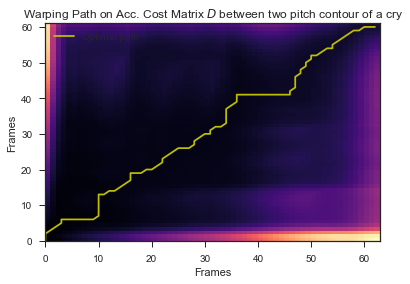

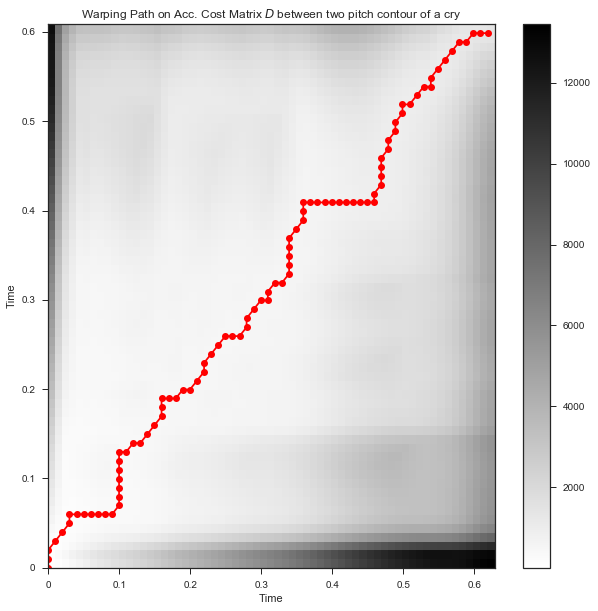

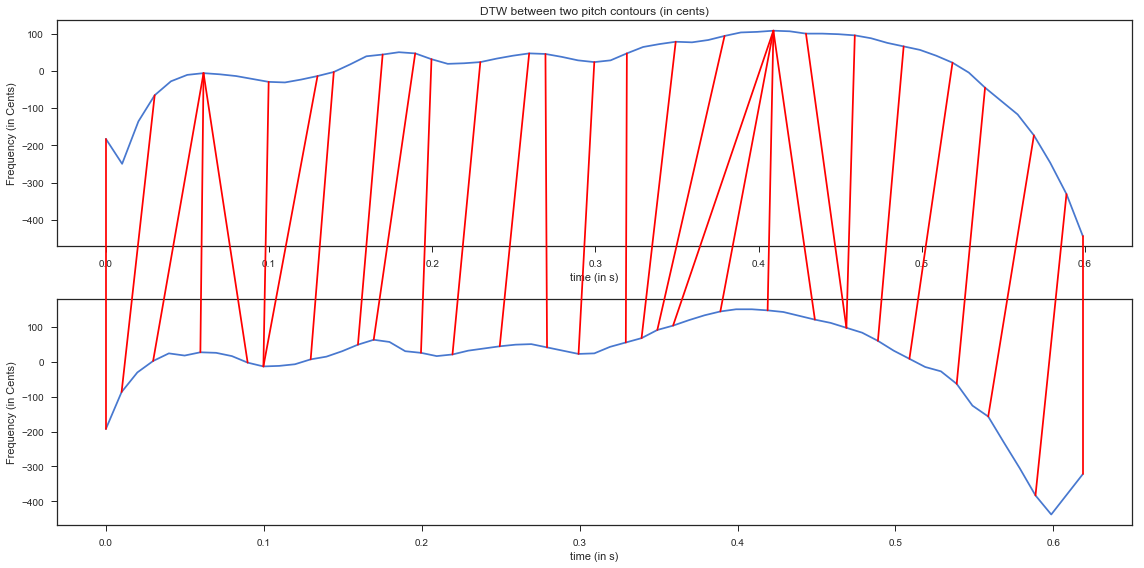

In [251]:
def correct_pitch_contour(pitch_contour):
    results = [float(t) for t in pitch_contour[0:len(pitch_contour)-1].split(' ') if ((t.find('[')==-1)&(len(t)>0))]
    return results

selected_pitch_contours = pd.DataFrame.from_csv('selected_pitch_contours.csv',sep='\t',index_col=None)
selected_pitch_contours['pitch_contour']=selected_pitch_contours['pitch_contour'].apply(correct_pitch_contour)
selected_pitch_contours['baby_id']=selected_pitch_contours['baby_id'].apply(correct_baby_id)

# INIT PARAMETERS

REF = 110 # Ref for Hz -> cent conversion

HOP_SIZE = 440 # Swipe hop_size

FS = 44100

# TEST on two differents signals

X1 = np.array([311,321,329,332,334,330,331,333,329,311])
X2 = selected_pitch_contours.iloc[0]['pitch_contour']

X_cents = np.asarray(map(lambda x: 1200*math.log(x/float(REF), 2), X2))
X_cents = X_cents - mean(X_cents)

Y1 = np.array([411,421,429,432,434,430,431,433,429,411])
Y2 = selected_pitch_contours.iloc[1]['pitch_contour']

Y_cents = np.asarray(map(lambda x: 1200*math.log(x/float(REF), 2), Y2))
Y_cents = Y_cents - mean(Y_cents)

# Weights on the three possible steps (D, H, V)

weights_mul = np.array([2, 1, 1]) #No priviligied direction

# Applies global constraints to the cost matrix C 

global_constraints = True

# Sakoe-Chiba band radius (1/2 of the width) will be int(radius*min(C.shape)) with C the cost function

band_rad = 1  

if len(X_cents) > len(Y_cents):
    temp = X_cents
    X_cents = Y_cents
    Y_cents = temp
    
D, wp = librosa.dtw(X_cents, Y_cents,weights_mul=weights_mul, global_constraints=global_constraints,band_rad = band_rad)

print(D[len(X_cents)-1,len(Y_cents)-1])

# Display 1 : Warping Path on Acc. Cost Matrix (A first display)

librosa.display.specshow(D, x_axis='frames', y_axis='frames')
plt.title('Warping Path on Acc. Cost Matrix $D$ between two pitch contour of a cry')
plt.plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
plt.legend();

# Display 2 : Warping Path on Acc. Cost Matrix (A second display) 

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

wp_s = np.asarray(wp)*float(HOP_SIZE)/FS 

librosa.display.specshow(D,sr=FS, x_axis='time', y_axis='time',
                         cmap='gray_r', hop_length=HOP_SIZE)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$ between two pitch contour of a cry')
plt.colorbar();

# Display 3 : alignement of the two time series

fig = plt.figure(figsize=(16, 8))

axis1 = map(float,range(len(X_cents)))
axis1 = [x*float(HOP_SIZE)/FS for x in axis1]

axis2 = map(float,range(len(Y_cents)))
axis2 = [x*float(HOP_SIZE)/FS for x in axis2]
 
plt.subplot(2, 1, 1) # plot X_cents
plt.plot(axis1,X_cents)
plt.title('DTW between two pitch contours (in cents)')
plt.ylabel('Frequency (in Cents)')
plt.xlabel('time (in s)')
ax1 = plt.gca()

plt.subplot(2, 1, 2) # plot Y_cents
plt.plot(axis2,Y_cents)
plt.ylabel('Frequency (in Cents)')
plt.xlabel('time (in s)')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

for tp1, tp2 in wp[points_idx]:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([axis1[tp1], X_cents[tp1]]))
    coord2 = trans_figure.transform(ax2.transData.transform([axis2[tp2], Y_cents[tp2]]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r')
    lines.append(line)

    fig.lines = lines
    plt.tight_layout()

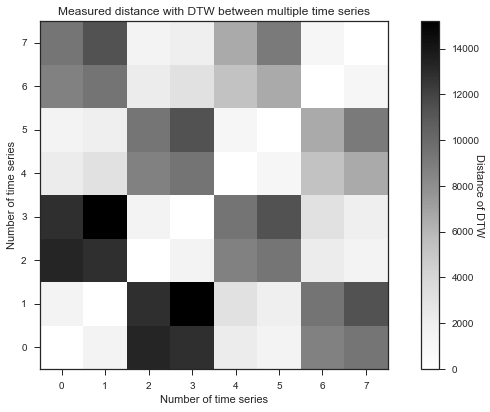

In [252]:
# Test on various signal to try different weights_mul and band_rad

X2 = selected_pitch_contours.iloc[0]['pitch_contour']
X_cents = np.asarray(map(lambda x: 1200*math.log(x/float(REF), 2), X2))
X_cents = X_cents - mean(X_cents)
#
X2 = selected_pitch_contours.iloc[1]['pitch_contour']
Y_cents = np.asarray(map(lambda x: 1200*math.log(x/float(REF), 2), Y2))
Y_cents = Y_cents - mean(Y_cents)

PC0 = X_cents
PC1 = Y_cents
PC2 = - X_cents
PC3 = - Y_cents
PC4 = X_cents*0.4
PC5 = Y_cents*0.6
PC6 = - X_cents*0.4
PC7 = - Y_cents*0.6

all_PC = {}
all_PC['PC0'] = PC0
all_PC['PC1'] = PC1
all_PC['PC2'] = PC2
all_PC['PC3'] = PC3
all_PC['PC4'] = PC4
all_PC['PC5'] = PC5
all_PC['PC6'] = PC6
all_PC['PC7'] = PC7

# Init parameters

weights_mul = np.array([2, 1, 1]) 

band_rad = 0.25

# Creation matrice distance

MAT_DTW_PC = np.zeros((len(all_PC),len(all_PC)))

for i in range(len(all_PC)):
    for j in range(i):
        PCA = all_PC['PC'+str(i)]
        PCB = all_PC['PC'+str(j)]
        if len(PCA) > len(PCB):
            temp = PCA
            PCA = PCB
            PCB = temp
        D, wp = librosa.dtw(PCA, PCB,weights_mul=weights_mul, global_constraints=global_constraints,band_rad = band_rad)
        DTW = D[len(PCA)-1,len(PCB)-1]
        MAT_DTW_PC[i,j] = DTW

MAT_DTW_PC = MAT_DTW_PC + MAT_DTW_PC.transpose()

# Display matrice distance
        
fig = plt.figure(figsize=(12, 6.4))
ax = fig.add_subplot(111)
ax.set_title('Measured distance with DTW between multiple time series')
plt.imshow(MAT_DTW_PC, origin='lower')
plt.xticks(np.arange(0, len(all_PC), dtype=np.int))
plt.xlabel('Number of time series')
plt.ylabel('Number of time series')
plt.yticks(np.arange(0, len(all_PC), dtype=np.int))
cbar = plt.colorbar(orientation='vertical');
cbar.set_label('Distance of DTW', rotation=270)


# Clustering time series (Algorithm Clarans)

Firstly we preprocessing (Hz -> Cents + centering)

In [3]:
def correct_baby_id(baby_id):
        return '0' + str(baby_id)

def correct_pitch_contour(pitch_contour):
    results = [float(t) for t in pitch_contour[0:len(pitch_contour)-1].split(' ') if ((t.find('[')==-1)&(len(t)>0))]
    return results

selected_pitch_contours = pd.DataFrame.from_csv('selected_pitch_contours.csv',sep='\t',index_col=None)
selected_pitch_contours['pitch_contour']=selected_pitch_contours['pitch_contour'].apply(correct_pitch_contour)
selected_pitch_contours['baby_id']=selected_pitch_contours['baby_id'].apply(correct_baby_id)

pitch_contour = []

for k in range(len(selected_pitch_contours)):
    pitch_contour = pitch_contour + [selected_pitch_contours.pitch_contour.iloc[k]]

# INIT PARAMETERS

ref = 110 # Ref for Hz -> cents conversion

# Hz -> + centering conversion

def pitch_contour_conversion(pitch_contour):
    X_cents = np.asarray(map(lambda x: 1200*math.log(x/float(ref), 2), pitch_contour))
    X_cents = X_cents - mean(X_cents)
    return X_cents

selected_pitch_contours['pitch_contour']=selected_pitch_contours['pitch_contour'].apply(pitch_contour_conversion)

In [ ]:
selected_pitch_contours

We define the function clarans_DTW : a time series clustering algorithm on large data_set (more than 100 datas)

In [ ]:
class clarans_DTW:
    """!
    @brief Class represents clustering algorithm CLARANS (a method for clustering objects for spatial data mining).
    """

    def __init__(self, data, number_clusters, numlocal, maxneighbor, weights_mul, global_constraints, band_rad):
        """!
        @brief Constructor of clustering algorithm CLARANS, here applied to time series.
        @details The higher the value of maxneighbor, the closer is CLARANS to K-Medoids (PAM - Partitioning Around Medoids), and the longer is each search of a local minima.
        
        @param[in] data (list): Input data that is presented as a list of times series
        @param[in] number_clusters (uint): amount of clusters that should be allocated.
        @param[in] numlocal (uint): the number of local minima obtained (amount of iterations for solving the problem).
        @param[in] maxneighbor (uint): the maximum number of neighbors examined.
        @param[in] weights_mul (uint): Weights on the three possible steps (D, H, V) of the DTW
        @param[in] global_constraints (bool): Applies global constraints to the cost matrix of the DTW
        @param[in] band_rad (floor): Sakoe-Chiba band radius (1/2 of the width) will be int(radius*min(C.shape)) with C the cost function
        
        """
        
        self.__pointer_data = data;
        self.__numlocal = numlocal;
        self.__maxneighbor = maxneighbor;
        self.__number_clusters = number_clusters;
        self.__weights_mul = weights_mul;
        self.__global_constraints = global_constraints;
        self.__band_rad = band_rad;
        
        # Gave a list of index of all data in each clusters
        self.__clusters = [];
        # Current list of medoids
        self.__current = [];
        # Cluster appartenance of each time series
        self.__belong = [];
        
        # Better medoids
        self.__optimal_medoids = [];
        # Optimal cost of clustering
        self.__optimal_estimation = float('inf');
    
    
    def process(self):
        """!
        @brief Performs cluster analysis in line with rules of CLARANS algorithm.
        
        @see get_clusters()
        @see get_medoids()
        
        """
        
        random.seed();
        
        for _ in range(0, self.__numlocal):
            # set (current) random medoids
            self.__current = random.sample(range(len(self.__pointer_data)), self.__number_clusters);
            
            # update clusters in line with random allocated medoids
            self.__update_clusters(self.__current);
            
            # optimize configuration : search better clustering in a sampled neighbourhood of medoids
            self.__optimize_configuration();
            
            # obtain cost of current cluster configuration and compare it with the best obtained
            estimation = self.__calculate_estimation();
            if (estimation < self.__optimal_estimation):
                self.__optimal_medoids = self.__current[:];
                self.__optimal_estimation = estimation;
        
        self.__update_clusters(self.__optimal_medoids);
    
    
    def get_clusters(self):
        """!
        @brief Returns allocated clusters by the algorithm.
        
        @remark Allocated clusters can be returned only after data processing (use method process()), otherwise empty list is returned.
        
        @return (list) List of allocated clusters, each cluster contains indexes of objects in list of data.
        
        @see process()
        @see get_medoids()
        
        """
        
        return self.__clusters;
    
    
    def get_medoids(self):
        
        """!
        @brief Returns list of medoids of allocated clusters.
        
        @see process()
        @see get_clusters()
        
        """

        return self.__optimal_medoids;
    
    def get_estimation(self):
        
        """!
        @brief Returns list of computed DTW
        
        @see process()
        
        """

        return self.__optimal_estimation;

    def __update_DTW_Matrix(self,index_point1,index_point2):
        
        D = librosa.dtw(self.__pointer_data[index_point1], self.__pointer_data[index_point2], weights_mul=self.__weights_mul, global_constraints=self.__global_constraints, band_rad = self.__band_rad)[0]
        dist = D[len(self.__pointer_data[index_point1])-1,len(self.__pointer_data[index_point2])-1]
        
        return dist;

    def __update_clusters(self, medoids):
        """!
        @brief Forms cluster in line with specified medoids by calculation distance from each point to medoids. 
        
        """
        
        self.__belong = [0] * len(self.__pointer_data);
        self.__clusters = [[] for i in range(len(medoids))];
        for index_point in range(len(self.__pointer_data)):
            index_optim = -1;
            dist_optim = 0.0;
            
            for index in range(len(medoids)):
                
                dist = self.__update_DTW_Matrix(index_point, medoids[index]);
                    
                if ( (dist < dist_optim) or (index is 0)):
                    index_optim = index;
                    dist_optim = dist;
             
            self.__clusters[index_optim].append(index_point);
            self.__belong[index_point] = index_optim;
        
        # If cluster is not able to capture object it should be removed
        self.__clusters = [cluster for cluster in self.__clusters if len(cluster) > 0];
    
    def __optimize_configuration(self):
        """!
        @brief Finds quasi-optimal medoids and updates in line with them clusters in line with algorithm's rules. 
        
        """
        index_neighbor = 0;
        while (index_neighbor < self.__maxneighbor):
            # get random current medoid that is to be replaced
            current_medoid_index = self.__current[random.randint(0, self.__number_clusters - 1)];
            current_medoid_cluster_index = self.__belong[current_medoid_index];
            
            # get new candidate to be medoid
            candidate_medoid_index = random.randint(0, len(self.__pointer_data) - 1);
            
            while (candidate_medoid_index in self.__current):
                candidate_medoid_index = random.randint(0, len(self.__pointer_data) - 1);
            
            candidate_cost = 0.0;
            for point_index in range(0, len(self.__pointer_data)):
                if (point_index not in self.__current):
                    # get non-medoid point and its medoid
                    point_cluster_index = self.__belong[point_index];
                    point_medoid_index = self.__current[point_cluster_index];
                    
                    # get other medoid that is nearest to the point (except current and candidate)
                    other_medoid_index = self.__find_another_nearest_medoid(point_index, current_medoid_index);
                    other_medoid_cluster_index = self.__belong[other_medoid_index];
                    
                    # for optimization calculate all required distances
                    # from the point to current medoid
                    
                    distance_current = self.__update_DTW_Matrix(point_index, current_medoid_index);
                    
                    # from the point to candidate medoid
                    
                    distance_candidate = self.__update_DTW_Matrix(point_index, candidate_medoid_index);
                    
                    # from the point to nearest medoid (except current and candidate)
                  
                    distance_nearest = self.__update_DTW_Matrix(point_index, other_medoid_index);
                    
                    # apply rules for cost calculation
                    if (point_cluster_index == current_medoid_cluster_index):
                        # case 1:
                        if (distance_candidate >= distance_nearest):
                            candidate_cost += distance_nearest - distance_current;
                        
                        # case 2:
                        else:
                            candidate_cost += distance_candidate - distance_current;
                    
                    elif (point_cluster_index == other_medoid_cluster_index):
                        # case 3 ('nearest medoid' is the representative object of that cluster and object is more similar to 'nearest' than to 'candidate'):
                        if (distance_candidate > distance_nearest):
                            pass;
                        
                        # case 4:
                        else:
                            candidate_cost += distance_candidate - distance_nearest;
            
            if (candidate_cost < 0):
                # set candidate that has won
                self.__current[current_medoid_cluster_index] = candidate_medoid_index;
                
                # recalculate clusters
                self.__update_clusters(self.__current);
                
                # reset iterations and starts investigation from the begining
                index_neighbor = 0;
                
            else:
                index_neighbor += 1;
    
    # Error : index_medoid instead of current_medoid_index
    
    def __find_another_nearest_medoid(self, point_index, current_medoid_index):
        """!
        @brief Finds the another nearest medoid for the specified point that is differ from the specified medoid. 
        
        @param[in] point_index: index of point in dataspace for that searching of medoid in current list of medoids is perfomed.
        @param[in] current_medoid_index: index of medoid that shouldn't be considered as a nearest.
        
        @return (uint) index of the another nearest medoid for the point.
        
        """
        other_medoid_index = -1;
        other_distance_nearest = float('inf');
        for index_medoid in self.__current:
            if (index_medoid != current_medoid_index):
                
                other_distance_candidate = self.__update_DTW_Matrix(point_index, index_medoid);
                
                if (other_distance_candidate < other_distance_nearest):
                    other_distance_nearest = other_distance_candidate;
                    other_medoid_index = index_medoid;
        
        return other_medoid_index;
    
    
    def __calculate_estimation(self):
        """!
        @brief Calculates estimation (cost) of the current clusters. The lower the estimation,
               the more optimally configuration of clusters.
        
        @return (double) estimation of current clusters.
        
        """
        estimation = 0.0;
        for index_cluster in range(len(self.__clusters)):
            cluster = self.__clusters[index_cluster];
            index_medoid = self.__current[index_cluster];
            for index_point in cluster:
                
                estimation += self.__update_DTW_Matrix(index_point, index_medoid);
        
        return estimation;

As we use a very large dataset ( > 20000 datas), we will use a CLARA algorithm using CLARANS on samples instead of PAM.

In [ ]:
def clara_clarans_DTW(time_series, number_clusters, sample_size, iterations, maxneighbors, weights_mul, global_constraints, band_rad):
    
    #Initialisation 
    optimal_medoids = [];
    optimal_estimation = float('inf');
    optimal_compacity_clusters = [];
    
    for _ in range(5):
        random_sample = random.sample(range(len(time_series)), sample_size)
                
        # CLARANS on sampled data
        time_series_sampled = [time_series[i] for i in random_sample]
        clarans_instance = clarans_DTW(time_series_sampled, number_clusters, iterations, maxneighbors, weights_mul, global_constraints, band_rad);
        clarans_instance.process();
        
        # Estimation on all data_sets
        optimal_sampled_medoids = clarans_instance.get_medoids();
        optimal_sampled_medoid_index = [random_sample[i] for i in optimal_sampled_medoids]
        clusters = update_clusters(time_series, optimal_sampled_medoid_index, weights_mul, global_constraints, band_rad)[0]
        estimation, compacity_clusters = calculate_estimation(time_series, clusters, optimal_sampled_medoid_index, weights_mul, global_constraints, band_rad)
        if(estimation < optimal_estimation):
            optimal_estimation = estimation
            optimal_medoids = optimal_sampled_medoid_index
            optimal_compacity_clusters = compacity_clusters
    clusters = update_clusters(time_series, optimal_medoids, weights_mul, global_constraints, band_rad)[0]
    return clusters, optimal_medoids, optimal_estimation, optimal_compacity_clusters 
    
def calculate_estimation(time_series, clusters, medoid, weights_mul, global_constraints, band_rad):
    estimation = 0.0;
    compacity_clusters = [];
    for index_cluster in range(len(clusters)):
        compacity_cluster = 0.0;
        cluster = clusters[index_cluster];
        index_medoid = medoid[index_cluster];
        for index_point in cluster:
            DTW_distance = update_DTW_Matrix(time_series, index_point, index_medoid, weights_mul, global_constraints, band_rad);
            estimation += DTW_distance
            compacity_cluster += DTW_distance
        compacity_clusters = compacity_clusters + [compacity_cluster/float(len(cluster))]
    return estimation, compacity_clusters;

def update_clusters(time_series, medoids, weights_mul, global_constraints, band_rad):

    belong = [0] * len(time_series);
    clusters = [[] for i in range(len(medoids))];
    for index_point in range(len(time_series)):
        index_optim = -1;
        dist_optim = 0.0;
        
        for index in range(len(medoids)):
            dist = update_DTW_Matrix(time_series, index_point, medoids[index], weights_mul, global_constraints, band_rad);
            if ((dist < dist_optim) or (index is 0)):
                index_optim = index;
                dist_optim = dist;
        clusters[index_optim].append(index_point);
        belong[index_point] = index_optim;
    # If cluster is not able to capture object it should be removed
    clusters = [cluster for cluster in clusters if len(cluster) > 0];
    return clusters, belong

def update_DTW_Matrix(time_series,index_point1,index_point2, weights_mul, global_constraints, band_rad):
    D = librosa.dtw(time_series[index_point1], time_series[index_point2], weights_mul= weights_mul, global_constraints= global_constraints, band_rad = band_rad)[0]
    dist = D[len(time_series[index_point1])-1,len(time_series[index_point2])-1]
    return dist

Creation of matrix of data

In [4]:
# time_series data
size_dataset_time_series = len(selected_pitch_contours)

time_series = []
per_none_interpo = []
start_expiration = []
duration_expiration = []
audio_file_path = []

for i in range(size_dataset_time_series):
    time_series = time_series + [selected_pitch_contours.iloc[i]['pitch_contour']]
    per_none_interpo = per_none_interpo + [selected_pitch_contours.iloc[i]['per_none_interpo']]
    start_expiration = start_expiration + [selected_pitch_contours.iloc[i]['start']]  
    duration_expiration = duration_expiration + [selected_pitch_contours.iloc[i]['duration']]
    audio_file_path = audio_file_path + [selected_pitch_contours.iloc[i]['audio_file_path']]

In [ ]:
# Plot histogram of all duration : 80% between 0 and 1 second

n, bins, patches = plt.hist(duration_expiration, bins = 'auto');
print('Number of Expiration : ' + str(n[0:20]))
print('Bins of duration : ' + str(bins[0:21]))
plt.title("Histogram of duration of expiration");
plt.xlabel("Value of duration (in ms)");
plt.xlim([0,1000])
plt.ylabel("Frequency");

Clustering for different k

In [ ]:
iterations = 2
sample_size = 1000
weights_mul = np.array([2, 1, 1]) 
global_constraints = True
band_rad = 0.1

number_clusters = 2
maxneighbors = int(round(0.0125*number_clusters*(sample_size-number_clusters)))

# CLARANS algorithm k = 2

start = time.time()
clusters1, optimal_medoids1, optimal_estimation1, compacity_clusters1 = clara_clarans_DTW(time_series, number_clusters, sample_size, iterations, maxneighbors,weights_mul,global_constraints,band_rad);
end = time.time()
print(end - start)

In [ ]:
number_clusters = 3
maxneighbors = int(round(0.0125*number_clusters*(sample_size-number_clusters)))

# CLARANS algorithm k = 3

start = time.time()
clusters2, optimal_medoids2, optimal_estimation2, compacity_clusters2 = clara_clarans_DTW(time_series, number_clusters, sample_size, iterations, maxneighbors,weights_mul,global_constraints,band_rad);
end = time.time()
print(end - start)

In [ ]:
number_clusters = 4
maxneighbors = int(round(0.0125*number_clusters*(sample_size-number_clusters)))

# CLARANS algorithm k = 4

start = time.time()
clusters3, optimal_medoids3, optimal_estimation3, compacity_clusters3 = clara_clarans_DTW(time_series, number_clusters, sample_size, iterations, maxneighbors,weights_mul,global_constraints,band_rad);
end = time.time()
print(end - start)

In [ ]:
number_clusters = 5
maxneighbors = int(round(0.0125*number_clusters*(sample_size-number_clusters)))

# CLARANS algorithm k = 5

start = time.time()
clusters4, optimal_medoids4, optimal_estimation4, compacity_clusters4 = clara_clarans_DTW(time_series, number_clusters, sample_size, iterations, maxneighbors,weights_mul,global_constraints,band_rad);
end = time.time()
print(end - start)

In [ ]:
number_clusters = 6
maxneighbors = int(round(0.0125*number_clusters*(sample_size-number_clusters)))

# CLARANS algorithm k = 6

start = time.time()
clusters5, optimal_medoids5, optimal_estimation5, compacity_clusters5 = clara_clarans_DTW(time_series, number_clusters, sample_size, iterations, maxneighbors,weights_mul,global_constraints,band_rad);
end = time.time()
print(end - start)

In [ ]:
number_clusters = 7
maxneighbors = int(round(0.0125*number_clusters*(sample_size-number_clusters)))

# CLARANS algorithm k = 7

start = time.time()
clusters6, optimal_medoids6, optimal_estimation6, compacity_clusters6 = clara_clarans_DTW(time_series, number_clusters, sample_size, iterations, maxneighbors,weights_mul,global_constraints,band_rad);
end = time.time()
print(end - start)

In [ ]:
number_clusters = 8
maxneighbors = int(round(0.0125*number_clusters*(sample_size-number_clusters)))

# CLARANS algorithm k = 8

start = time.time()
clusters7, optimal_medoids7, optimal_estimation7, compacity_clusters7 = clara_clarans_DTW(time_series, number_clusters, sample_size, iterations, maxneighbors,weights_mul,global_constraints,band_rad);
end = time.time()
print(end - start)

In [ ]:
number_clusters = 9
maxneighbors = int(round(0.0125*number_clusters*(sample_size-number_clusters)))

# CLARANS algorithm k = 9

start = time.time()
clusters8, optimal_medoids8, optimal_estimation8, compacity_clusters8 = clara_clarans_DTW(time_series, number_clusters, sample_size, iterations, maxneighbors,weights_mul,global_constraints,band_rad);
end = time.time()
print(end - start)

Save clusters 

In [122]:
all_clusters = {}
all_clusters['clusters1'] = clusters1
all_clusters['clusters2'] = clusters2
all_clusters['clusters3'] = clusters3
all_clusters['clusters4'] = clusters4
all_clusters['clusters5'] = clusters5
all_clusters['clusters6'] = clusters6
all_clusters['clusters7'] = clusters7
all_clusters['clusters8'] = clusters8

np.save('all_clusters.npy', all_clusters)

all_optimal_medoids = {}
all_optimal_medoids['optimal_medoids1'] = optimal_medoids1
all_optimal_medoids['optimal_medoids2'] = optimal_medoids2
all_optimal_medoids['optimal_medoids3'] = optimal_medoids3
all_optimal_medoids['optimal_medoids4'] = optimal_medoids4
all_optimal_medoids['optimal_medoids5'] = optimal_medoids5
all_optimal_medoids['optimal_medoids6'] = optimal_medoids6
all_optimal_medoids['optimal_medoids7'] = optimal_medoids7
all_optimal_medoids['optimal_medoids8'] = optimal_medoids8

np.save('all_optimal_medoids.npy', all_optimal_medoids)

all_compacity_clusters = {}
all_compacity_clusters['compacity_clusters1'] = compacity_clusters1
all_compacity_clusters['compacity_clusters2'] = compacity_clusters2
all_compacity_clusters['compacity_clusters3'] = compacity_clusters3
all_compacity_clusters['compacity_clusters4'] = compacity_clusters4
all_compacity_clusters['compacity_clusters5'] = compacity_clusters5
all_compacity_clusters['compacity_clusters6'] = compacity_clusters6
all_compacity_clusters['compacity_clusters7'] = compacity_clusters7
all_compacity_clusters['compacity_clusters8'] = compacity_clusters8

np.save('all_compacity_clusters.npy', all_compacity_clusters)

NameError: name 'clusters1' is not defined

We now choose k

In [ ]:
# Search for elbow point

axis = [2,3,4,5,6,7,8,9]

optimal_estimation1 = 52296208.599524878
optimal_estimation2 = 45948909.03598284
optimal_estimation3 = 44192257.60516759
optimal_estimation4 = 41114328.305629186
optimal_estimation5 = 39954813.372435041
optimal_estimation6 = 37958668.298182145
optimal_estimation7 = 37231241.40754097
optimal_estimation8 = 36079329.843272269

y = [optimal_estimation1, optimal_estimation2, optimal_estimation3, optimal_estimation4, optimal_estimation5, optimal_estimation6, optimal_estimation7, optimal_estimation8]

plt.plot(axis, y)

title('Estimation (cost) of the current clusters in function of the Number of clusters');
plt.xlabel('Number of clusters');
plt.ylabel('Estimation (cost) of the current clusters');

In [123]:
# Relative size of clusters for different k

all_clusters = np.load('all_clusters.npy').item()
all_compacity_clusters = np.load('all_compacity_clusters.npy').item()

all_relative_clusters_size_2dec = {}

for k in range(8):
    clusters = all_clusters['clusters'+str(k+1)]
    compacity_clusters = all_compacity_clusters['compacity_clusters'+str(k+1)] 
    relative_clusters_size = []
    for j in range(k+2):
        relative_clusters_size = relative_clusters_size + [(len(clusters[j])/float(size_dataset_time_series))*100]
    print("--------------------")
    print("Relative size of clusters for k = " + str(k+2) + " in % :")
    relative_clusters_size_2dec = ["{0:0.2f}".format(x) for x in relative_clusters_size]
    all_relative_clusters_size_2dec['relative_clusters'+str(k+1)] = relative_clusters_size_2dec 
    print(str(relative_clusters_size_2dec))  
    #
    print("Compacity of clusters for k = " + str(k+2) + ' :')
    compacity_clusters = ["{0:0.2f}".format(x) for x in compacity_clusters]
    print(str(compacity_clusters))
    print("")

--------------------
Relative size of clusters for k = 2 in % :
['38.31', '61.69']
Compacity of clusters for k = 2 :
['4338.39', '4971.33']

--------------------
Relative size of clusters for k = 3 in % :
['26.89', '30.40', '42.71']
Compacity of clusters for k = 3 :
['4986.90', '3187.60', '4319.53']

--------------------
Relative size of clusters for k = 4 in % :
['34.18', '13.27', '24.91', '27.63']
Compacity of clusters for k = 4 :
['4307.91', '6488.63', '3643.33', '2730.91']

--------------------
Relative size of clusters for k = 5 in % :
['13.19', '24.32', '28.06', '9.49', '24.95']
Compacity of clusters for k = 5 :
['2181.55', '4030.31', '2714.55', '6538.82', '4565.18']

--------------------
Relative size of clusters for k = 6 in % :
['5.60', '17.20', '22.26', '9.19', '20.24', '25.52']
Compacity of clusters for k = 6 :
['9081.12', '3197.06', '1889.31', '4793.16', '2372.72', '4579.88']

--------------------
Relative size of clusters for k = 7 in % :
['20.49', '19.47', '9.56', '12.21'

After choosing k = 8, we now plot medoids

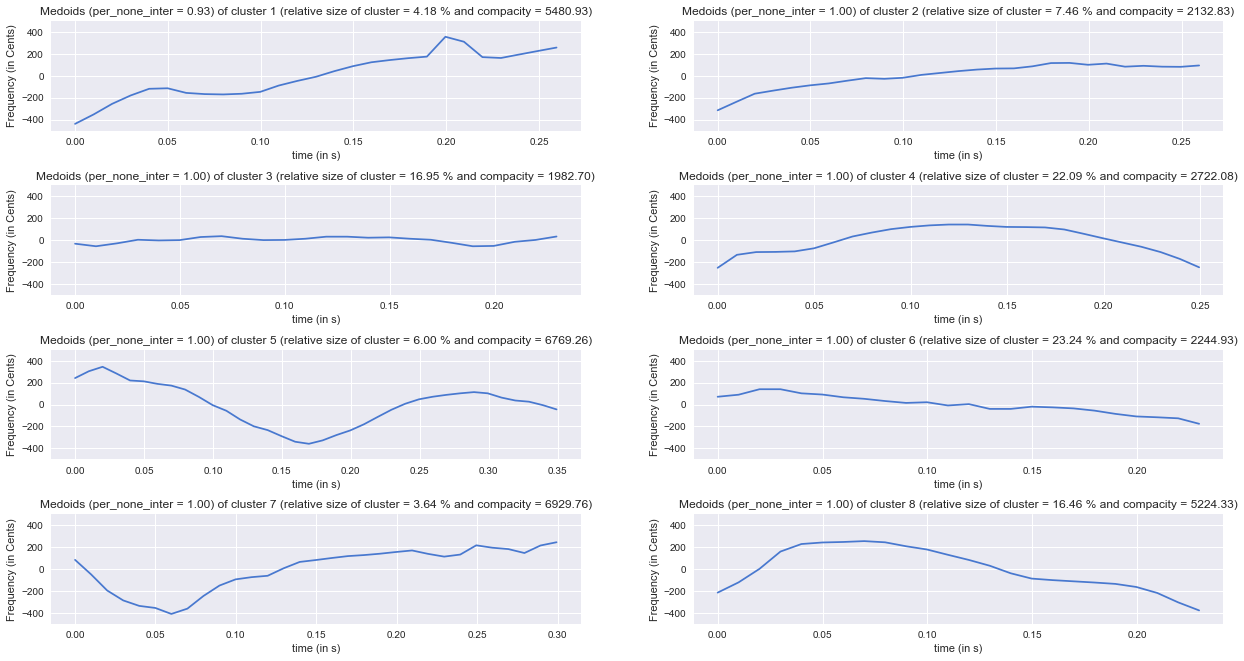

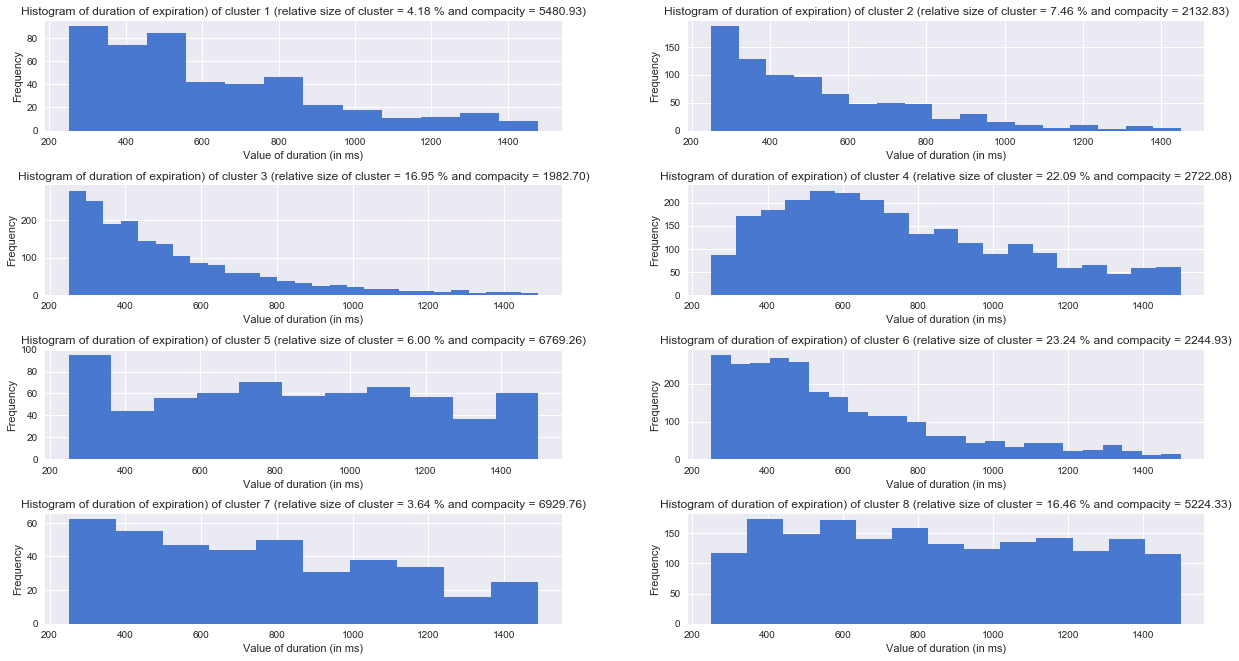

In [124]:
# plot medoids for one number of clusters

number_clusters = 8

HOP_SIZE = 440 # Swipe hop_size
FS = 44100

all_optimal_medoids = np.load('all_optimal_medoids.npy').item()
optimal_medoids = all_optimal_medoids['optimal_medoids'+str(number_clusters-1)]

relative_clusters_size_2dec = all_relative_clusters_size_2dec['relative_clusters'+str(number_clusters-1)]
compacity_clusters = all_compacity_clusters['compacity_clusters'+str(number_clusters-1)]

plt.rcParams['figure.figsize'] = (18, 18)

# Plot all the medoids

plt.figure()

for j in range(number_clusters):
    if (j < int(j/2)):
        ax = plt.subplot(number_clusters,1,j+1)
    else:
        ax = plt.subplot(number_clusters,2,j+1)
    #
    axis = map(float,range(len(time_series[optimal_medoids[j]])))
    axis = [x*float(HOP_SIZE)/FS for x in axis]
    ax.plot(axis,time_series[optimal_medoids[j]]);
    #
    title('Medoids (per_none_inter = ' + "{0:0.2f}".format(per_none_interpo[optimal_medoids[j]]) + ') of cluster ' + str(j+1) + ' (relative size of cluster = ' + str(relative_clusters_size_2dec[j]) + ' % and compacity = ' + "{0:0.2f}".format(compacity_clusters[j]) + ')')
    plt.ylabel('Frequency (in Cents)')
    plt.xlabel('time (in s)')
    ax.set_ylim([-500, 500])

plt.tight_layout()

# Plot corresponding histograms for each clusters

all_clusters = np.load('all_clusters.npy').item()
clusters = all_clusters['clusters'+str(number_clusters-1)]

plt.rcParams['figure.figsize'] = (18, 18)

plt.figure()

for j in range(number_clusters):
    if (j < int(j/2)):
        plt.subplot(number_clusters,1,j+1)
    else:
        plt.subplot(number_clusters,2,j+1)
    duration_clusters = [duration_expiration[x] for x in clusters[j]]
    plt.hist(duration_clusters, bins = 'auto');
    plt.title("Histogram of duration of expiration" + ') of cluster ' + str(j+1) + ' (relative size of cluster = ' + str(relative_clusters_size_2dec[j]) + ' % and compacity = ' + "{0:0.2f}".format(compacity_clusters[j]) + ')');
    plt.ylabel('Frequency')
    plt.xlabel("Value of duration (in ms)");
    
plt.tight_layout()

We now examine tendencies inside clusters 

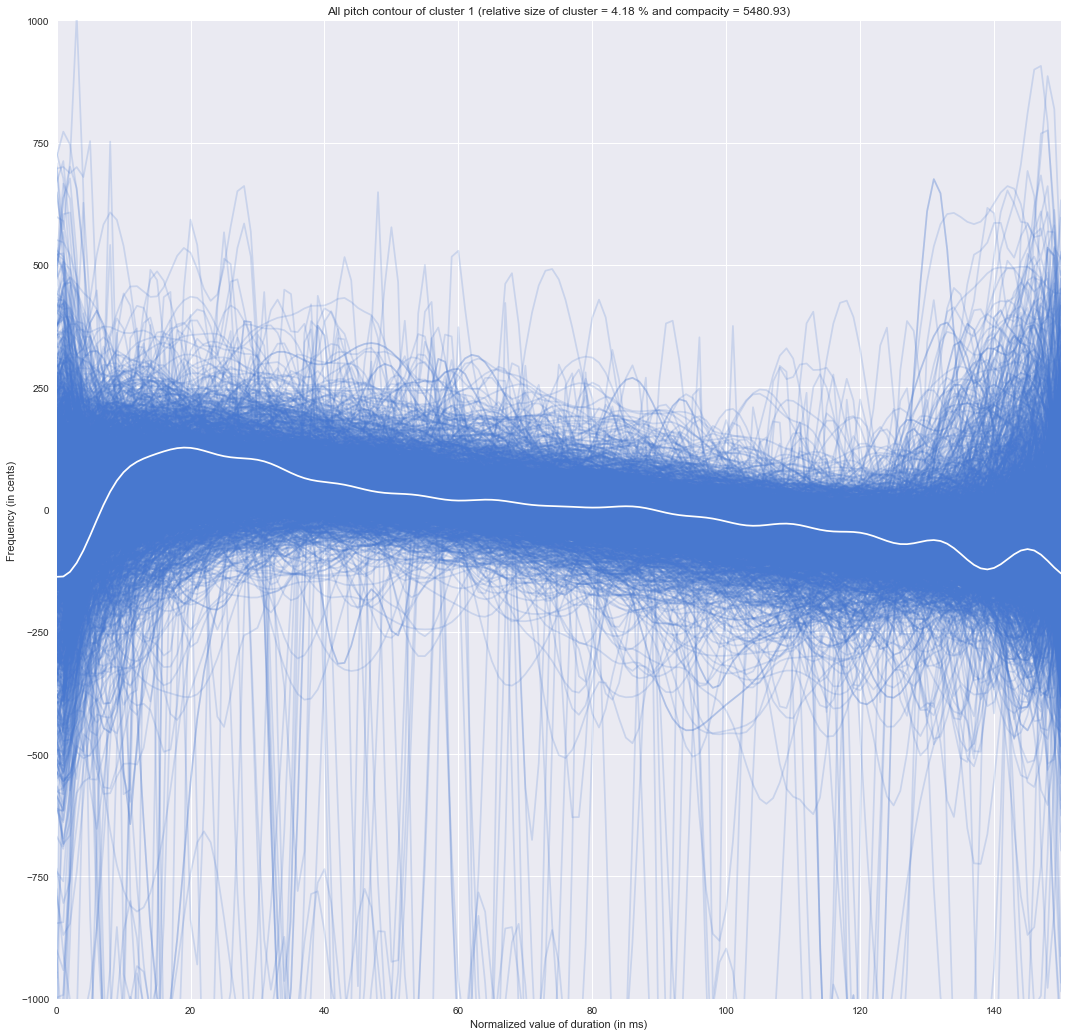

In [125]:
# If we want to plot all the figures of a cluster on the same plot

number_clusters = 7
index_cluster = 0

clusters = all_clusters['clusters'+str(number_clusters-1)]
cluster = clusters[index_cluster]

optimal_medoids = all_optimal_medoids['optimal_medoids'+str(number_clusters-1)]

len_max_signal = 0

for j in range(len(cluster)):
    if (len_max_signal < len(time_series[cluster[j]])):
        len_max_signal = len(time_series[cluster[j]])

resampled_cluster = []

for j in range(len(cluster)):
    resampled_cluster = resampled_cluster + [scipy.signal.resample(time_series[cluster[j]], len_max_signal)]

ax = sb.tsplot(data = np.array(resampled_cluster), err_style="unit_traces")

medoid = scipy.signal.resample(time_series[optimal_medoids[index_cluster]], len_max_signal)

ax = sb.tsplot(data = np.array(medoid), color = 'w')

plt.title("All pitch contour" + ' of cluster ' + str(index_cluster+1) + ' (relative size of cluster = ' + str(relative_clusters_size_2dec[index_cluster]) + ' % and compacity = ' + "{0:0.2f}".format(compacity_clusters[index_cluster]) + ')');
plt.ylabel('Frequency (in cents)')
plt.xlabel("Normalized value of duration (in ms)");
ax.set_ylim([-1000,1000]);
sb.set_style('whitegrid') #make whitegrid
sb.set_style('ticks') #clean ticks (useful when exporting to pdf)

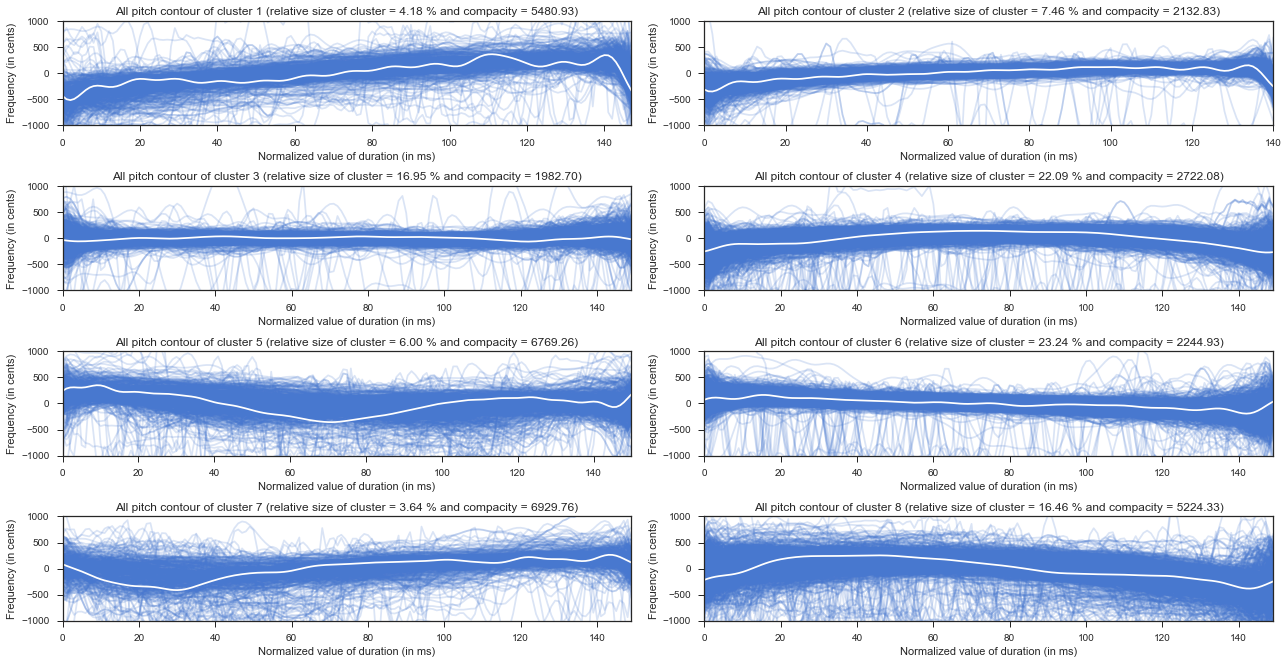

In [126]:
# If we want to plot all the figures of a cluster on the same plot

number_clusters = 8

all_clusters = np.load('all_clusters.npy').item()
clusters = all_clusters['clusters'+str(number_clusters-1)]

plt.figure()

optimal_medoids = all_optimal_medoids['optimal_medoids'+str(number_clusters-1)]

relative_clusters_size_2dec = all_relative_clusters_size_2dec['relative_clusters'+str(number_clusters-1)]
compacity_clusters = all_compacity_clusters['compacity_clusters'+str(number_clusters-1)]

for k in range(number_clusters):
        
    cluster = clusters[k]

    len_max_signal = 0

    for j in range(len(cluster)):
        if (len_max_signal < len(time_series[cluster[j]])):
            len_max_signal = len(time_series[cluster[j]])

    resampled_cluster = []

    for j in range(len(cluster)):
        resampled_cluster = resampled_cluster + [scipy.signal.resample(time_series[cluster[j]], len_max_signal)]
    
    if (k < int(k/2)):
        plt.subplot(number_clusters,1,k+1)
    else:
        plt.subplot(number_clusters,2,k+1)
    
    ax = sb.tsplot(data = np.array(resampled_cluster), err_style="unit_traces")
    medoid = scipy.signal.resample(time_series[optimal_medoids[k]], len_max_signal)
    ax = sb.tsplot(data = np.array(medoid), color = 'w')
    
    plt.title("All pitch contour" + ' of cluster ' + str(k+1) + ' (relative size of cluster = ' + str(relative_clusters_size_2dec[k]) + ' % and compacity = ' + "{0:0.2f}".format(compacity_clusters[k]) + ')');
    plt.ylabel('Frequency (in cents)')
    plt.xlabel("Normalized value of duration (in ms)");
    ax.set_ylim([-1000,1000]);
    sb.set_style('whitegrid') #make whitegrid
    sb.set_style('ticks') #clean ticks (useful when exporting to pdf)
    
plt.tight_layout()

plt.rcParams['figure.figsize'] = (27, 18)

Plot random series in a cluster and hear the corresponding cry

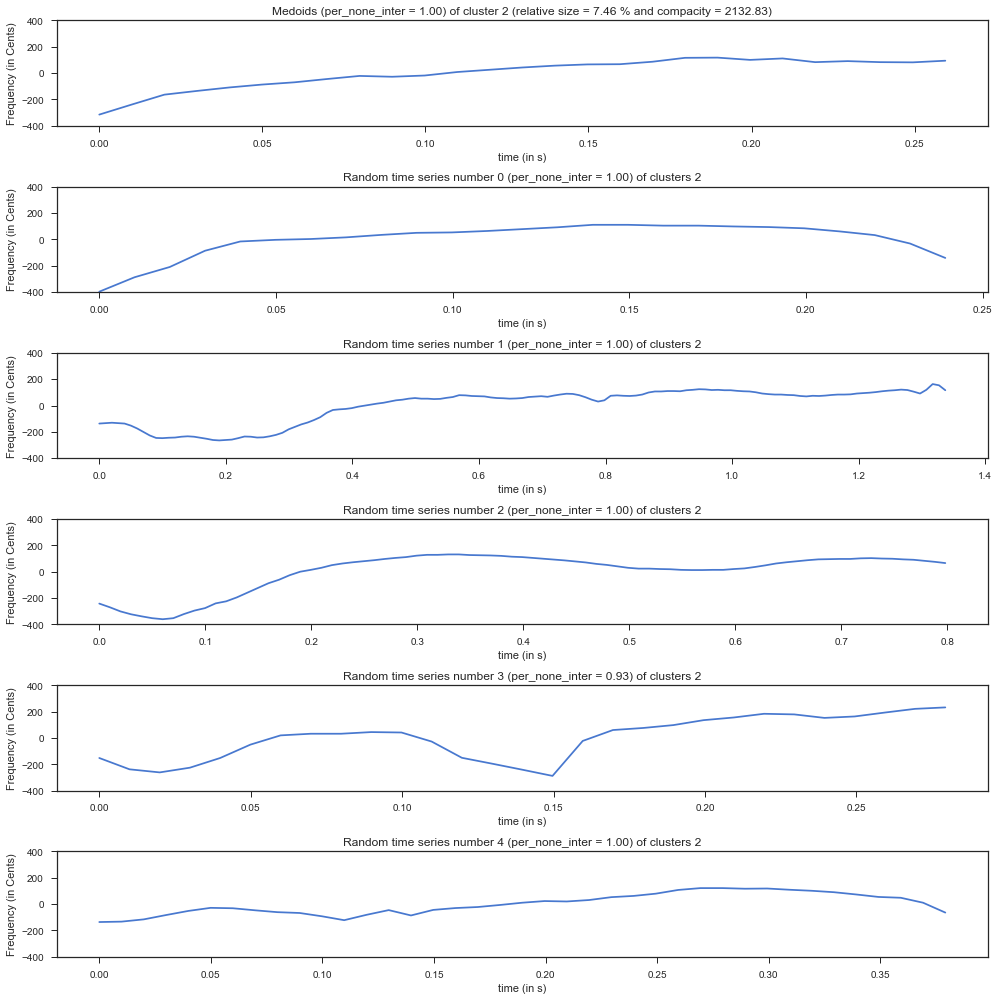

In [128]:
# plot one medoids and random time series in his clusters

number_clusters = 8

HOP_SIZE = 440 # Swipe hop_size
FS = 44100

all_optimal_medoids = np.load('all_optimal_medoids.npy').item()
optimal_medoids = all_optimal_medoids['optimal_medoids'+str(number_clusters-1)]

relative_clusters_size_2dec = all_relative_clusters_size_2dec['relative_clusters'+str(number_clusters-1)]
compacity_clusters = all_compacity_clusters['compacity_clusters'+str(number_clusters-1)]

plt.rcParams['figure.figsize'] = (14, 14)

# Plot the medoids chosen

index_medoids = 1
plt.figure()

axis = map(float,range(len(time_series[optimal_medoids[index_medoids]])))
axis = [x*float(HOP_SIZE)/FS for x in axis]
ax = plt.subplot(6, 1, 1)
ax.plot(axis,time_series[optimal_medoids[index_medoids]]);
title('Medoids (per_none_inter = ' + "{0:0.2f}".format(per_none_interpo[optimal_medoids[index_medoids]]) + ') of cluster ' + str(index_medoids+1) + ' (relative size = ' + str(relative_clusters_size_2dec[index_medoids]) + ' % and compacity = ' + "{0:0.2f}".format(compacity_clusters[index_medoids]) + ')')
plt.ylabel('Frequency (in Cents)')
plt.xlabel('time (in s)')
ax.set_ylim([-400, 400])

# Plot random time series from his clusters

all_clusters = np.load('all_clusters.npy').item()
clusters = all_clusters['clusters'+str(number_clusters-1)]
random_time_series = random.sample(clusters[index_medoids], 5)

for j in range(5):
    ax = plt.subplot(6, 1, j+2)
    #
    axis = map(float,range(len(time_series[random_time_series[j]])))
    axis = [x*float(HOP_SIZE)/FS for x in axis]
    ax.plot(axis,time_series[random_time_series[j]]);
    ax.set_ylim([-400, 400])
    #
    title('Random time series number ' + str(j) + ' (per_none_inter = ' + "{0:0.2f}".format(per_none_interpo[random_time_series[j]]) + ') of clusters ' + str(index_medoids+1))
    plt.ylabel('Frequency (in Cents)')
    plt.xlabel('time (in s)')

plt.tight_layout()

In [130]:
# Hearing the expiration phase corresponding to the chosen medois

print('----- Phase of expiration corresponding to Medoids of cluster ' + str(index_medoids+1))

audio_data = librosa.load(audio_file_path[optimal_medoids[index_medoids]], offset = start_expiration[optimal_medoids[index_medoids]]/float(1000), duration = duration_expiration[optimal_medoids[index_medoids]]/float(1000),sr = FS)[0]
audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))
IPython.display.Audio(audio_data, rate=FS)

----- Phase of expiration corresponding to Medoids of cluster 2


In [139]:
# Hearing the random expiration corresponding to random time series number

number_random_time_series = 0
print('----- Phase of expiration corresponding to random time series number ' + str(number_random_time_series) + ' of cluster ' + str(index_medoids+1))
audio_data = librosa.load(audio_file_path[random_time_series[number_random_time_series]], offset = start_expiration[random_time_series[number_random_time_series]]/float(1000), duration = duration_expiration[random_time_series[number_random_time_series]]/float(1000),sr = FS)[0]
audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))
IPython.display.Audio(audio_data, rate=FS)

----- Phase of expiration corresponding to random time series number 0 of cluster 2


In [196]:
number_random_time_series = 0
print('----- Phase of expiration corresponding to random time series number ' + str(number_random_time_series) + ' of cluster ' + str(index_medoids+1))
audio_data = librosa.load(audio_file_path[random_time_series[number_random_time_series]], offset = start_expiration[random_time_series[number_random_time_series]]/float(1000), duration = duration_expiration[random_time_series[number_random_time_series]]/float(1000),sr = FS)[0]
audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))
IPython.display.Audio(audio_data, rate=FS)

----- Phase of expiration corresponding to random time series number 0 of cluster 2


In [133]:
number_clusters = 8

all_clusters = np.load('all_clusters.npy').item()

clusters = all_clusters['clusters'+str(number_clusters-1)]

class_pitch_contour = np.zeros(len(time_series))

class_pitch_contour = [int(x) for x in class_pitch_contour]

for k in range(len(clusters)):
    cluster = clusters[k]
    for j in range(len(cluster)):
        class_pitch_contour[cluster[j]] = int(k)
        
# We drop cluster 0
        
selected_pitch_contours['class_pitch_contour'] = pd.Series(class_pitch_contour, index=selected_pitch_contours.index)

classified_pitch_contours = selected_pitch_contours[['baby_id','sex','month','context','duration','pitch_contour','class_pitch_contour','audio_file_path']]

classified_pitch_contours = classified_pitch_contours[classified_pitch_contours.class_pitch_contour != 0]

# Study of distribution of clusters

In [6]:
# To convert '01m' to a int (too many degree of a liberty if we consider month as a categorical variable and not
# a continuous variable)
    
def correct_baby_month(month):
    return int(month[:-1])

In [7]:
month = ['00m','01m','02m','03m','04m','05m','06m','07m','08m','09m','10m','11m','12m','13m']

month = range(8)

context = ['hungry', 'pee', 'sleepy']

baby_id = ['011','012','042','043','044','045','046','047','048','049','050','051','052','053','054','055','056','057','058','059','060','061','062','063','064','065','066','067','068','069','070','071','072']

classified_pitch_contours['month']=classified_pitch_contours['month'].apply(correct_baby_month)
classified_pitch_contours_design = classified_pitch_contours[classified_pitch_contours.month.isin(month)]
classified_pitch_contours_design = classified_pitch_contours_design[classified_pitch_contours_design.context.isin(context)]

In [8]:
classified_pitch_contours_design

,baby_id,sex,month,context,duration,pitch_contour,class_pitch_contour,audio_file_path
0,011,F,0,hungry,670,"[-182.476672122, -249.666952137, -135.60323212...",3,/Users/vaglio/Desktop/BABY_STAGE/011/hungry/au...
1,011,F,0,hungry,650,"[-192.464407625, -86.210647623, -29.9638876182...",3,/Users/vaglio/Desktop/BABY_STAGE/011/hungry/au...
2,011,F,0,hungry,790,"[-242.905955015, -197.589035009, -89.778754997...",1,/Users/vaglio/Desktop/BABY_STAGE/011/hungry/au...
3,011,F,0,hungry,500,"[-214.48199998, -87.9182399848, 18.3355199865,...",3,/Users/vaglio/Desktop/BABY_STAGE/011/hungry/au...
4,011,F,0,hungry,610,"[-200.160901037, -95.4705010089, -22.033621031...",3,/Users/vaglio/Desktop/BABY_STAGE/011/hungry/au...
5,011,F,0,hungry,280,"[-252.199057787, -138.135337761, -60.015217782...",2,/Users/vaglio/Desktop/BABY_STAGE/011/hungry/au...
6,011,F,0,hungry,630,"[-126.895589499, -55.0220695263, 26.2316104915...",5,/Users/vaglio/Desktop/BABY_STAGE/011/hungry/au...
7,011,F,0,hungry,520,"[-145.586421157, -39.3395011973, 29.414138809,...",5,/Users/vaglio/Desktop/BABY_STAGE/011/hungry/au...
8,011,F,0,hungry,410,"[-159.729488981, -94.1025690072, -26.912289009...",2,/Users/vaglio/Desktop/BABY_STAGE/011/hungry/au...
9,011,F,0,hungry,730,"[-179.709333811, -134.392413817, -68.765493825...",3,/Users/vaglio/Desktop/BABY_STAGE/011/hungry/au...


In [12]:
baby_sex_data = pd.DataFrame.from_csv('baby_sex_data.csv',sep='\t',index_col=None, header = None)
baby_sex_data.columns = ['baby_id','sex']
baby_sex_data['baby_id']=baby_sex_data['baby_id'].apply(correct_baby_id)

sex = list(baby_sex_data.sex)

In [ ]:
# distribution clusters in function of months

baby_number = []
sex_baby = []
month_number = []
class_pitch_contour = []
frequency_class = []

plt.rcParams['figure.figsize'] = (18, 18)

# display the difference between sex if 1 else 0

display_sex = 1

for j in range(len(baby_id)):
    for k in range(len(month)):
        temp = classified_pitch_contours_design
        #
        temp = temp[temp.baby_id == baby_id[j]]
        temp = temp[temp.month == month[k]]
        temp_class_pitch_contours = list(temp.class_pitch_contour)
        c = Counter(temp_class_pitch_contours)
        sum_c = 0
        for i in range(7):
            sum_c += c[i+1]
        if (sum_c == 0):
            pourcentage = [NaN,NaN,NaN,NaN,NaN,NaN,NaN]
        else:
            pourcentage = ["{0:0.2f}".format(c[i+1]/float(sum_c)) for i in range(7)]
        for i in range(7):
            baby_number = baby_number + [baby_id[j]]
            sex_baby = sex_baby + [sex[j]]
            month_number = month_number + [month[k]]
            class_pitch_contour = class_pitch_contour + [str(i+1)]
            frequency_class = frequency_class + [float(pourcentage[i])]
            
distrib_culsters_month = pd.DataFrame({'baby_id' : baby_number,\
                                       'sex' : sex_baby,\
                                       'month' : month_number,\
                                       'number_of_cluster' : class_pitch_contour,\
                                       'frequency_of_class' : frequency_class
                                      })

distrib_culsters_month = distrib_culsters_month[['baby_id','sex','month','number_of_cluster','frequency_of_class']]

distrib_culsters_month = distrib_culsters_month.dropna(axis = 0)

#

if (display_sex == 1):
    g1 = sb.factorplot(x="number_of_cluster", y="frequency_of_class", hue="sex", row="month",row_order = month, data=distrib_culsters_month, kind="bar", size=4, aspect=4);
else:
    g1 = sb.factorplot(x="number_of_cluster", y="frequency_of_class", row="month",row_order = month, data=distrib_culsters_month, kind="bar", size=4, aspect=4);

#
        
if (display_sex == 1):
    g2 = sb.factorplot(x="month", order = month, y="frequency_of_class", hue="sex", row="number_of_cluster", data=distrib_culsters_month, size=2, aspect=4);
else:
    g2 = sb.factorplot(x="month", order = month, y="frequency_of_class", row="number_of_cluster", data=distrib_culsters_month, size=2, aspect=4);    

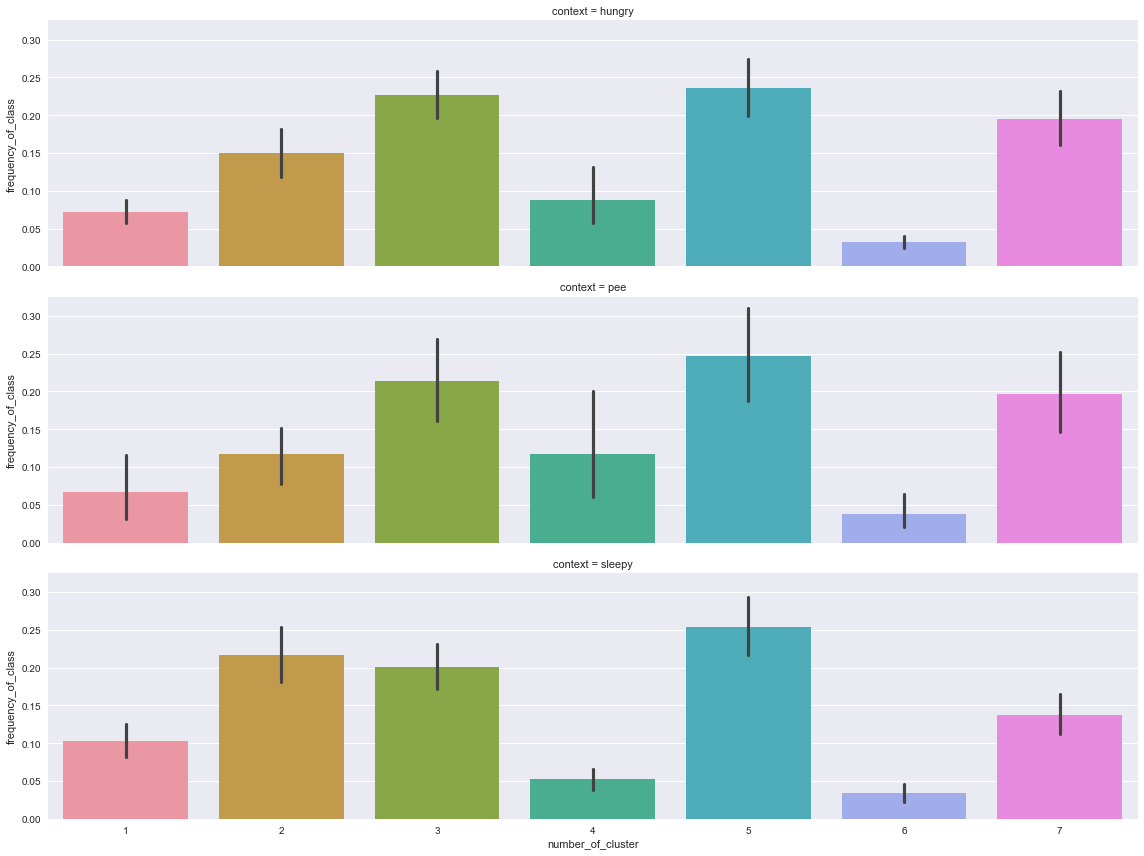

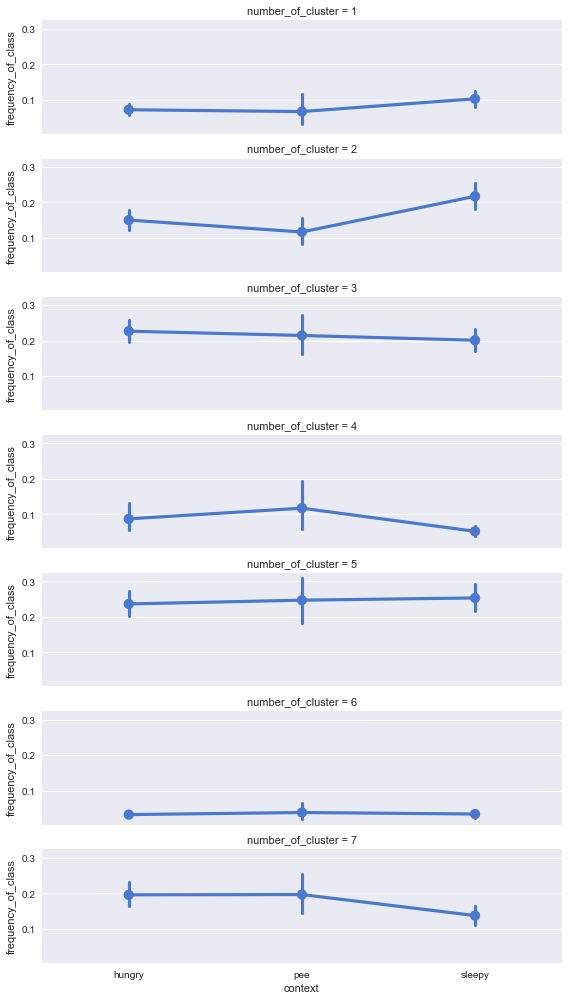

In [116]:
# distribution clusters in function of contexts

baby_number = []
sex_baby = []
context_number = []
class_pitch_contour = []
frequency_class = []

# display the difference between sex if 1 else 0

display_sex = 0

for j in range(len(baby_id)):
    for k in range(len(context)):
        temp = classified_pitch_contours
        #
        temp = temp[temp.baby_id == baby_id[j]]
        temp = temp[temp.context == context[k]]
        temp_class_pitch_contours = list(temp.class_pitch_contour)
        c = Counter(temp_class_pitch_contours)
        sum_c = 0
        for i in range(7):
            sum_c += c[i+1]
        if (sum_c == 0):
            pourcentage = [NaN,NaN,NaN,NaN,NaN,NaN,NaN]
        else:
            pourcentage = ["{0:0.2f}".format(c[i+1]/float(sum_c)) for i in range(7)]
        for i in range(7):
            baby_number = baby_number + [baby_id[j]]
            sex_baby = sex_baby + [sex[j]]
            context_number = context_number + [context[k]]
            class_pitch_contour = class_pitch_contour + [str(i+1)]
            frequency_class = frequency_class + [float(pourcentage[i])]
            
distrib_culsters_context = pd.DataFrame({'baby_id' : baby_number,\
                                       'sex' : sex_baby,\
                                       'context' : context_number,\
                                       'number_of_cluster' : class_pitch_contour,\
                                       'frequency_of_class' : frequency_class
                                      })

distrib_culsters_context = distrib_culsters_context[['baby_id','sex','context','number_of_cluster','frequency_of_class']]

distrib_culsters_context = distrib_culsters_context.dropna(axis = 0)

if (display_sex == 1):
    g1 = sb.factorplot(x="number_of_cluster", y="frequency_of_class",hue="sex", row="context", data=distrib_culsters_context, kind="bar", size=4, aspect=4);
else:
    g1 = sb.factorplot(x="number_of_cluster", y="frequency_of_class", row="context", data=distrib_culsters_context, kind="bar", size=4, aspect=4);

#

plt.rcParams['figure.figsize'] = (18, 36)
        
if (display_sex == 1):
    g2 = sb.factorplot(x="context", y="frequency_of_class",hue="sex", row="number_of_cluster", data=distrib_culsters_context, size=2, aspect=4);
else:
    g2 = sb.factorplot(x="context", y="frequency_of_class", row="number_of_cluster", data=distrib_culsters_context, size=2, aspect=4);    

In [ ]:
# distribution clusters in function of months and contexts 

baby_number = []
sex_baby = []
month_number = []
class_pitch_contour = []
frequency_class = []
context_name = []
month_context_name = []

x_order = []

for j in range(len(month)):
    for k in range(len(context)):
        x_order = x_order + ['0' + str(month[j]) + 'm-' + context[k]]

plt.rcParams['figure.figsize'] = (18, 18)

#

for j in range(len(baby_id)):
    for k in range(len(month)):
        for l in range(len(context)):
            temp = classified_pitch_contours_design
            #
            temp = temp[temp.baby_id == baby_id[j]]
            temp = temp[temp.month == month[k]]
            temp = temp[temp.context == context[l]]
            temp_class_pitch_contours = list(temp.class_pitch_contour)
            c = Counter(temp_class_pitch_contours)
            sum_c = 0
            for i in range(7):
                sum_c += c[i+1]
            if (sum_c == 0):
                pourcentage = [NaN,NaN,NaN,NaN,NaN,NaN,NaN]
            else:
                pourcentage = ["{0:0.2f}".format(c[i+1]/float(sum_c)) for i in range(7)]
            for i in range(7):
                baby_number = baby_number + [baby_id[j]]
                sex_baby = sex_baby + [sex[j]]
                month_number = month_number + [month[k]]
                context_name = context_name + [context[l]]
                class_pitch_contour = class_pitch_contour + [str(i+1)]
                frequency_class = frequency_class + [float(pourcentage[i])]
                month_context_name = month_context_name + ['0' + str(month[k]) + 'm-' + context[l]]
            
distrib_culsters_month_context = pd.DataFrame({'baby_id' : baby_number,\
                                       'sex' : sex_baby,\
                                       'month' : month_number,\
                                       'context' : context_name,\
                                       'month_and_context' : month_context_name,\
                                       'number_of_cluster' : class_pitch_contour,\
                                       'frequency_of_class' : frequency_class
                                      })

distrib_culsters_month_context = distrib_culsters_month_context[['baby_id','sex','month','context','month_and_context','number_of_cluster','frequency_of_class']]

distrib_culsters_month_context = distrib_culsters_month_context.dropna(axis = 0)

g1h = sb.factorplot(x="number_of_cluster", y="frequency_of_class", row="month", row_order = month, col = "context", col_order = context,data=distrib_culsters_month_context, kind="bar",size=8, aspect=1);

In [ ]:
plt.rcParams['figure.figsize'] = (20, 30)

for k in range(7):
    temp = distrib_culsters_month_context[distrib_culsters_month_context.number_of_cluster == str(k+1)]
    temp = temp.groupby(['month', 'context'])['frequency_of_class'].mean().reset_index()
    temp = temp.pivot("month", "context", "frequency_of_class")
    plt.subplot(7, 2, k+1)
    ax = sb.heatmap(temp, vmin = 0, vmax = 0.5, annot=True)
    title('Distribution of clusters ' + str(k+1) + ' of male')

plt.tight_layout()

In [ ]:
# distribution clusters in function of months and contexts for male only

plt.rcParams['figure.figsize'] = (18, 18)

distrib_culsters_month_contextm = distrib_culsters_month_context[distrib_culsters_month_context.sex == 'M']

distrib_culsters_month_contextf = distrib_culsters_month_context[distrib_culsters_month_context.sex == 'F']

g1h = sb.factorplot(x="number_of_cluster", y="frequency_of_class", row="month", row_order = month, col = "context", col_order = context,data=distrib_culsters_month_contextm, kind="bar",size=8, aspect=1);

In [ ]:
plt.rcParams['figure.figsize'] = (20, 30)

for k in range(7):
    temp = distrib_culsters_month_contextm[distrib_culsters_month_contextm.number_of_cluster == str(k+1)]
    temp = temp.groupby(['month', 'context'])['frequency_of_class'].mean().reset_index()
    temp = temp.pivot("month", "context", "frequency_of_class")
    plt.subplot(7, 2, k+1)
    ax = sb.heatmap(temp, vmin = 0, vmax = 0.5, annot=True)
    title('Distribution of clusters ' + str(k+1) + ' of male')

plt.tight_layout()

In [ ]:
# distribution clusters in function of months and contexts for Female only

plt.rcParams['figure.figsize'] = (18, 18)

g1f = sb.factorplot(x="number_of_cluster", y="frequency_of_class", row="month", row_order = month, col = "context",data=distrib_culsters_month_contextf, kind="bar",size=8, aspect=1);

In [ ]:
plt.rcParams['figure.figsize'] = (20, 30)

for k in range(7):
    temp = distrib_culsters_month_contextf[distrib_culsters_month_contextf.number_of_cluster == str(k+1)]
    temp = temp.groupby(['month', 'context'])['frequency_of_class'].mean().reset_index()
    temp = temp.pivot("month", "context", "frequency_of_class")
    plt.subplot(7, 2, k+1)
    ax = sb.heatmap(temp, vmin = 0, vmax = 0.5, annot=True)
    title('Distribution of clusters ' + str(k+1) + ' of female')

plt.tight_layout()

We now apply LME to see if month and context are  statistically significance for class pitch contour.
As lme4 only estimate logistic regression model, we estimate a logistic model for each case. For this, we reduce the dataset to only two class_pitch_contour possible (0 is one class, 1 all the others).
It is made possible by begg and gray approximation.

In [9]:
# Same design as design 2 => all babies, 8 months, 3 contexts

choice_classe = 1

def define_two_class_pitch(class_pitch_contour, choice_classe):
    if(class_pitch_contour == choice_classe):
        return 0
    else:
        return 1
    
    
def function_glme_binomial1(choice_classe,classified_pitch_contours_design):
    temp_design = classified_pitch_contours_design.copy()    
    temp_design = temp_design[['baby_id','sex','month','context','class_pitch_contour']]
    temp_design['class_pitch_contour'] = temp_design['class_pitch_contour'].apply(define_two_class_pitch, args=(choice_classe,))
    rdf_lme=pandas2ri.py2ri(temp_design)

    # print(R.summary(rdf_lme))

    # Case ANOVA

    fml_nul = Formula("class_pitch_contour ~ 1 + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v0 = Formula("class_pitch_contour ~ month + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v1 = Formula("class_pitch_contour ~ context + month + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v2 = Formula("class_pitch_contour ~ month * context + (1 | baby_id) + (0 + month * context | baby_id)")

    nul = lme4.glmer(fml_nul, data = rdf_lme, family = 'binomial')
    v0 = lme4.glmer(fml_v0, data = rdf_lme, family = 'binomial') 
    v1 = lme4.glmer(fml_v1, data = rdf_lme, family = 'binomial') 
    v2 = lme4.glmer(fml_v2, data = rdf_lme, family = 'binomial')

    print(R.anova(nul,v0,v1,v2))

    
def function_glme_binomial2(choice_classe,classified_pitch_contours_design):
    temp_design = classified_pitch_contours_design.copy()    
    temp_design = temp_design[['baby_id','sex','month','context','class_pitch_contour']]
    temp_design['class_pitch_contour'] = temp_design['class_pitch_contour'].apply(define_two_class_pitch, args=(choice_classe,))
    rdf_lme=pandas2ri.py2ri(temp_design)

    # print(R.summary(rdf_lme))

    # Case ANOVA

    fml_nul = Formula("class_pitch_contour ~ 1 + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v0 = Formula("class_pitch_contour ~ sex + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v1 = Formula("class_pitch_contour ~ sex + month + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v2 = Formula("class_pitch_contour ~ sex + month + context + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v31 = Formula("class_pitch_contour ~ sex * month + context + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v32 = Formula("class_pitch_contour ~ sex * context + month + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v33 = Formula("class_pitch_contour ~ sex + month * context + (1 | baby_id) + (0 + month * context | baby_id)")
    fml_v4 = Formula("class_pitch_contour ~ sex * month * context + (1 | baby_id) + (0 + month * context | baby_id)")

    nul = lme4.glmer(fml_nul, data = rdf_lme, family = 'binomial')
    v0 = lme4.glmer(fml_v0, data = rdf_lme, family = 'binomial') 
    v1 = lme4.glmer(fml_v1, data = rdf_lme, family = 'binomial') 
    v2 = lme4.glmer(fml_v2, data = rdf_lme, family = 'binomial')
    v31 = lme4.glmer(fml_v31, data = rdf_lme, family = 'binomial')
    v32 = lme4.glmer(fml_v32, data = rdf_lme, family = 'binomial')
    v33 = lme4.glmer(fml_v33, data = rdf_lme, family = 'binomial')
    v4 = lme4.glmer(fml_v4, data = rdf_lme, family = 'binomial')

    print(R.anova(nul,v0,v1,v2,v31,v4))
    print(R.anova(nul,v0,v1,v2,v32,v4))
    print(R.anova(nul,v0,v1,v2,v33,v4))

In [ ]:
start = time.time()
function_glme_binomial1(1,classified_pitch_contours_design)
end = time.time()
print(end - start)

start = time.time()
function_glme_binomial2(1,classified_pitch_contours_design)
end = time.time()
print(end - start)

In [10]:
print('-----1-----')
start = time.time()
function_glme_binomial2(1,classified_pitch_contours_design)
end = time.time()
print('-----------')

print('-----2-----')
function_glme_binomial2(2,classified_pitch_contours_design)
print('-----------')

print('-----3-----')
function_glme_binomial2(3,classified_pitch_contours_design)
print('-----------')

print('-----4-----')
function_glme_binomial2(4,classified_pitch_contours_design)
print('-----------')

print('-----5-----')
function_glme_binomial2(5,classified_pitch_contours_design)
print('-----------')

print('-----6-----')
function_glme_binomial2(6,classified_pitch_contours_design)
print('-----------')

print('-----7-----')
function_glme_binomial2(7,classified_pitch_contours_design)
print('-----------')

-----1-----
Data: structure(list(baby_id = structure(c(1L, 1L, 1L, 1L, 1L, 1L,  ...
Models:
MODEL1: class_pitch_contour ~ 1 + (1 | baby_id) + (0 + month * context | 
MODEL1:     baby_id)
MODEL2: class_pitch_contour ~ sex + (1 | baby_id) + (0 + month * context | 
MODEL2:     baby_id)
MODEL3: class_pitch_contour ~ sex + month + (1 | baby_id) + (0 + month * 
MODEL3:     context | baby_id)
MODEL4: class_pitch_contour ~ sex + month + context + (1 | baby_id) + 
MODEL4:     (0 + month * context | baby_id)
MODEL5: class_pitch_contour ~ sex * context + month + (1 | baby_id) + 
MODEL5:     (0 + month * context | baby_id)
MODEL6: class_pitch_contour ~ sex * month * context + (1 | baby_id) + 
MODEL6:     (0 + month * context | baby_id)
       Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)   
MODEL1 23 3490.7 3647.6 -1722.4   3444.7                            
MODEL2 24 3490.9 3654.6 -1721.5   3442.9 1.8196      1   0.177363   
MODEL3 25 3486.1 3656.6 -1718.1   3436.1 6.7932      1   0.

# Experiment : free sorting experiment

<h1> Perceptual validation of pitch contour clustering </h1>

This notebook is used to analyse results from a Tcl-LabX free sort experiment (2017-7) in which participants grouped  35 short baby cries (5 instances from 7 computationally generated clusters) into an arbitrary number of clusters corresponding to their perceptual similarity. Individual sorts are aggregated into a global co-occurrence matrix, which is then subjected to hierarchical clustering. We then evaluate whether computationally generated clusters distribute coherently with these perceptual clusters. 

<h4> 1) Parse result files</h4>

Data collected in each configuration correspond to the same set of stimuli, only presented in random order. In order to collate stimuli co-occurrences across participants, we need to give a unique id to each stimulus. To do so, we first build a list of the sound files (nb_stim=35), as a pd.Dataframe, by scanning the listing.txt file of a random participant (subject_id=10)

In [242]:
# list stimuli
result_path = "configs/"
subject_id = 10 #use one sample subject id to list all stimuli
nb_stim = 35
names = []
clusters= []
listing_file = result_path + "configs" + str(subject_id) + "/results/" + str(subject_id) + "-listing.txt"
with open(listing_file, mode ='rU') as f:
    lines = [line.rstrip('\n') for line in f]
lines = lines[3:nb_stim+3] #3 lines of headers before list of stims
for line in lines:
    [stim_id, stim_name]=line.split('\t')
    [id1,str1,str2,contour_id,cluster_id] = stim_name.split('_')
    names.append(contour_id)
    clusters.append(cluster_id.split('.')[0])
stim_df = pd.DataFrame.from_dict({'name':names, 'cluster':clusters})

stim_df.head()

,cluster,name
0,7,7841
1,6,1268
2,2,8806
3,2,7906
4,5,1181


We then scan the result files from each participant (in subject_ids, to be updated with complete list), convert the randomized stimulus id into the corresponding unique contour id using the index prestored above, and then cumulatively build a (nb_stim,nb_stim) co-occurrence matrix (which values range between 0 and n_subjects).

In [243]:
subject_ids = [2,3,4,6,7,8,9,10,11]
result_path = "configs/"

cooc_matrix = np.zeros((nb_stim,nb_stim))

for subject_id in subject_ids:
    
    # build stim order correspondance
    stim_order = {}
    listing_file = result_path + "configs" + str(subject_id) + "/results/" + str(subject_id) + "-listing.txt"
    if  (subject_id < 10):
        with open(listing_file,mode='U') as f:
            lines = [line.rstrip('\n') for line in f]
    else:
        with open(listing_file,mode='rU') as f:
            lines = [line.rstrip('\n') for line in f]
    lines = lines[3:nb_stim+3] #3 lines of headers before list of stims
    for line in lines:
        [stim_id, stim_name]=line.split('\t')
        [id1,str1,str2,contour,cluster] = stim_name.split('_')
        contour_id = stim_df[stim_df['name']==contour].index.tolist()[0]    
        stim_order[stim_id]=contour_id
        
    # read co-occurrences
    result_file = result_path + "configs" + str(subject_id) + "/results/" + str(subject_id) + "-class.txt"
    if (subject_id < 10):
        with open(result_file,mode='U') as f:
            lines = [line.rstrip('\n') for line in f]
    else:
        with open(result_file,mode='rU') as f:
            lines = [line.rstrip('\n') for line in f]
    lines = lines[1:]
    for cluster in lines:
        items = cluster.split('\t')
        for pair in itertools.product(items,repeat=2):
            cooc_matrix[stim_order[pair[0]],stim_order[pair[1]]]=cooc_matrix[stim_order[pair[0]],stim_order[pair[1]]]+1



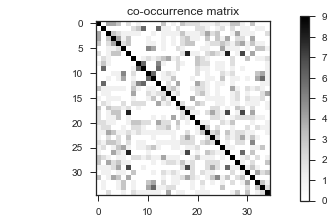

In [246]:
fig = plt.figure(figsize=(6, 3.2))
ax = fig.add_subplot(111)
ax.set_title('co-occurrence matrix')
plt.imshow(cooc_matrix)
ax.set_aspect('equal')
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

<h4> 2) Hierarchical clustering </h4>

We build hierarchical clusters based on the above co-occurrence data. scipy.cluster.hierarchy needs to operate on a distance, rather than similarity, matrix, so we first convert to distances using max-cooc, and then convert it to a compressed distance matrix (required as input by the hierarchy.linkage method)

In [247]:
#convert cooccurrences to distances (max - cooc)
max_count = np.max(cooc_matrix)
n = cooc_matrix.shape[0]
dist_matrix = max_count*np.ones((n,n))-cooc_matrix

#compress dist matrix for scipy.linkage
X = squareform(dist_matrix)

We then build clusters with linkage (default method: ward; would be useful to try other methods if needed), and display the corresponding dendrogram

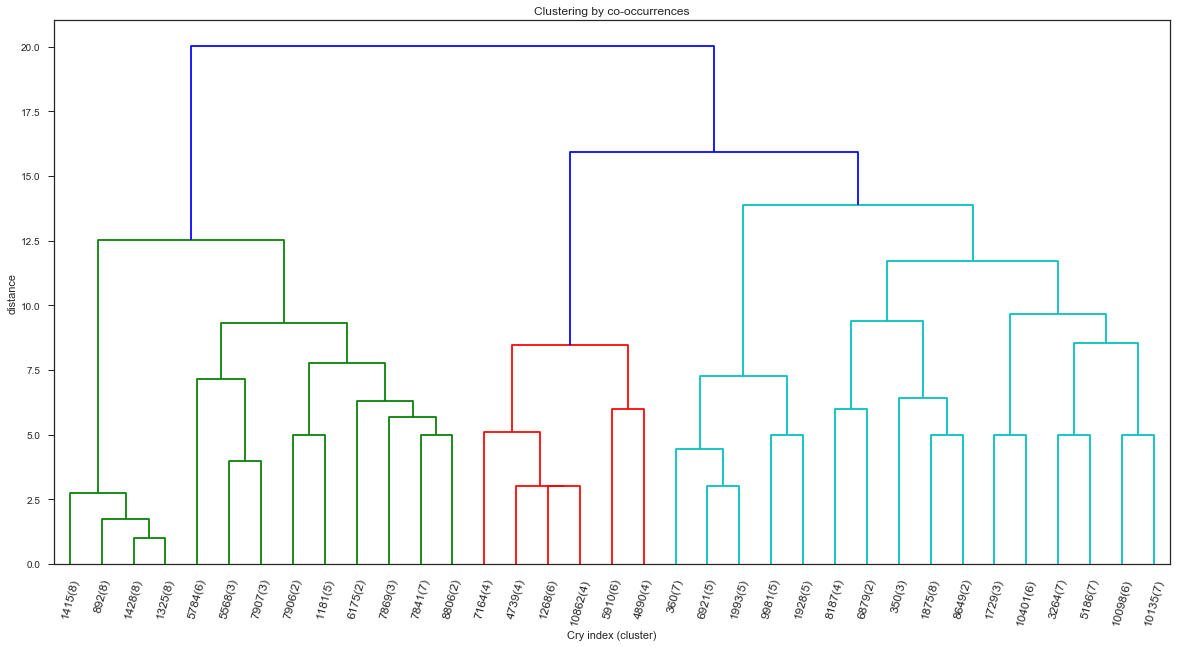

In [248]:
Z = linkage(X, 'ward')

# function to change label display from contour id to filename and cluster; would be interesting to also display context
label = lambda id: str(stim_df.get_value(index=id,col='name'))+"("+ stim_df.get_value(index=id,col='cluster')+")"

plt.figure(figsize=(20, 10))
plt.title('Clustering by co-occurrences')
plt.xlabel('Cry index (cluster)')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=75.,  # rotates the x axis labels
    leaf_font_size=12,  # font size for the x axis labels
    labels = map(label,range(0,35))
)
plt.show()